# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 1

In [2]:
cluster = '1'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 642
Num noneffect sequences: 642


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref  alt major  \
59   chr11   86103987   86103988    rs1237999      A         G   G    A     A   
42   chr11   60251676   60251677     rs636317      T         C   C    T     T   
65   chr12   33530906   33530907     rs935534      G         A   G    A     G   
418  chr19   45326535   45326536     rs344791      C         G   G    C     C   
583   chr4   89837895   89837896    rs2619363    NAN       NAN   G  C,T     G   
304  chr17   46130520   46130521   rs10514904      T         C   C    T     C   
404  chr19   45001090   45001091   rs35577563      C         G   C    G     C   
575   chr4   89836583   89836584    rs2619361      A         C   C    A     C   
567   chr4   89818510   89818511    rs2737022      A         C   A    C     A   
629   chr8   27369272   27369273     rs755951      A         C   A  C,T     A   
231  chr17   45894775   45894776   rs11575896      G         A   G    A     G   
498   chr3  122458998  122458999   rs56118506      T         C   C    T     C   
23   chr11   10516033   10516034   rs73411920      T         G   G    T     G   
276  chr17   45966269   45966270   rs62063292      T         C   C    T     C   
68   chr12   40224294   40224295    rs1388597      G         A   A    G     A   
388  chr19   44954426   44954427   rs10426750      C         G   G  A,C     C   
223  chr17   45852871   45852872   rs79589869      C         A   C    A     C   
363  chr19   44644418   44644419   rs10426401      T         G   T    G     T   
513   chr4     960458     960459    rs3733345      T         G   G  A,T     T   
536   chr4   89717375   89717376    rs7681312      G         C   C    G     C   
601   chr6   27762683   27762684    rs7759217      G         A   A    G     A   
188  chr17   45740531   45740532   rs80157557      G         A   G    A     G   
563   chr4   89800728   89800729   rs17016188      T         C   T    C     T   
145  chr17    5327571    5327572   rs56125028      A         G   G    A     G   
419   chr2   95076707   95076708    rs3105100      C         A   A    C     C   
156  chr17   45639518   45639519     rs413778      A         G   A    G     A   
36   chr11   60169283   60169284     rs617135      G         A   A    G     A   
542   chr4   89723356   89723357    rs8180214      G         A   G    A     G   
239  chr17   45896285   45896286   rs62056780      T         C   C  G,T     C   
589   chr5  102971887  102971888    rs6881225      T         C   T    C     T   
..     ...        ...        ...          ...    ...       ...  ..  ...   ...   
495   chr3   52531185   52531186   rs59078569      G         A   G    A     G   
281  chr17   45997252   45997253   rs62063854      G         A   G    A     G   
84   chr14   74713030   74713031    rs2270425      G         C   C    G     C   
485   chr3   52237762   52237763  rs146527642      G         C   G    C     G   
296  chr17   46038945   46038946   rs62062136      T         C   T    C     T   
389  chr19   44954888   44954889    rs3760629      A         C   A    C     C   
525   chr4   76238563   76238564    rs1441920      G         A   A    G     A   
545   chr4   89753279   89753280     rs356168      A         G   G    A     G   
224  chr17   45870121   45870122   rs56398500      G         A   A    G     A   
570   chr4   89836142   89836143    rs1372518    NAN       NAN   A    C     C   
320  chr17   46213543   46213544   rs79861768      G         A   A    G     A   
624   chr8   22622474   22622475   rs11136093      G         C   C    G     C   
160  chr17   45667623   45667624   rs17687462      T         C   C    T     C   
454   chr2  134712485  134712486   rs17733977      G         A   G    A     G   
572   chr4   89836157   89836158    rs1372519      G         A   A    G     G   
44   chr11   60251787   60251788    rs3041800      G       GTA   G  GTA     G   
140  chr17    4909107    4909108   rs16954243      T         A   A    T     A   
462   chr2  168247488  168247489   rs7

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs1237999   ||    chr11 : 86103987 - 86103988   ||    Locus: 59   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  7.14E-16
Alzheimers_Kunkle_2019 		  1.46E-13
Alzheimers_Lambert_2013 	  4.68E-13

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 1.5385   ||   Center / 200bp : 0.5158
Noneffect Sequence : ATTATCTATGAGTCACCAAC


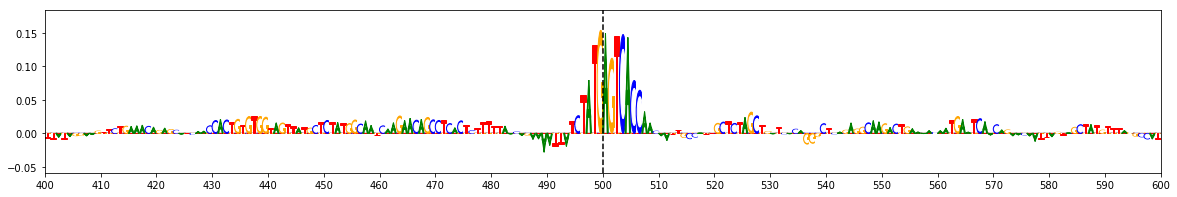

Effect Allele : A   ||   Explain Score : 0.2094   ||   Center / 200bp : 0.1267
Effect Sequence : ATTATCTATAAGTCACCAAC


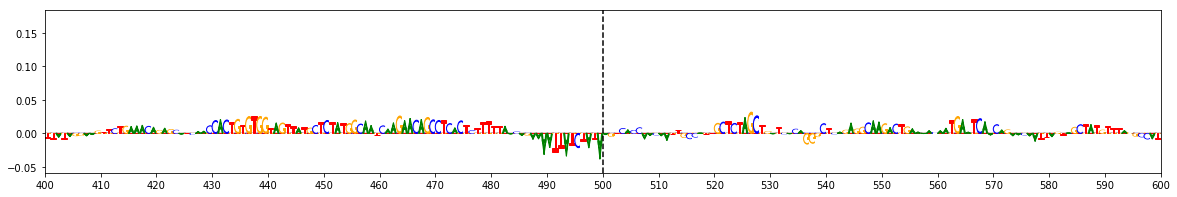

Allele Ratio : 0.1361   ||   Allele Difference : -1.5047  ||  ISM Score : -2.3447  ||  deltaSVM Score : -13.4142


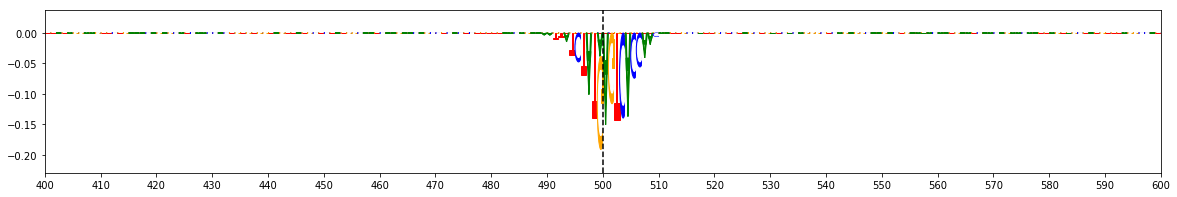


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs636317   ||    chr11 : 60251676 - 60251677   ||    Locus: 42   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  2.83E-13
Alzheimers_Kunkle_2019 		  5.91E-15
Alzheimers_Lambert_2013 	  1.41E-10

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 4.0494   ||   Center / 200bp : 0.8064
Noneffect Sequence : CTTTGCTGCCATCTGCTGGG


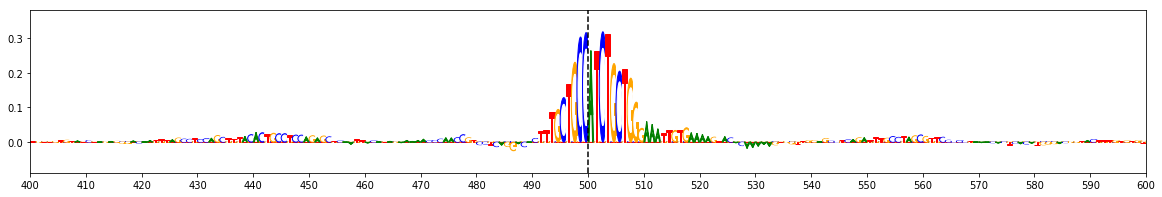

Effect Allele : T   ||   Explain Score : 1.6813   ||   Center / 200bp : 0.6335
Effect Sequence : CTTTGCTGCTATCTGCTGGG


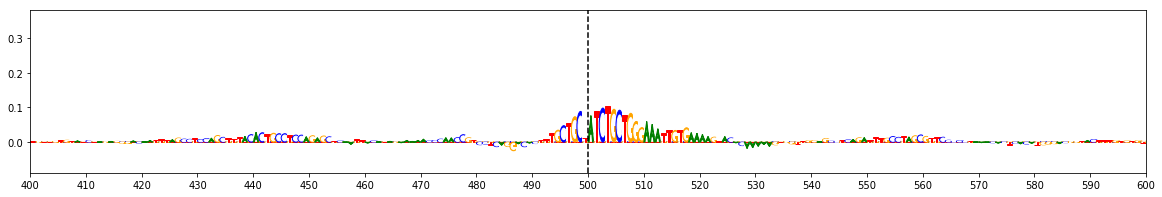

Allele Ratio : 0.4152   ||   Allele Difference : -2.3749  ||  ISM Score : -3.6942  ||  deltaSVM Score : -21.2882


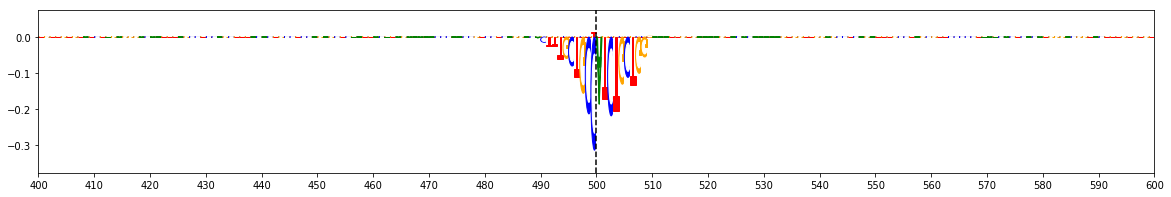


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs935534   ||    chr12 : 33530906 - 33530907   ||    Locus: 65   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.46E-07

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.7565   ||   Center / 200bp : 0.5874
Noneffect Sequence : TTTTGTCTTAGTCAGATGCT


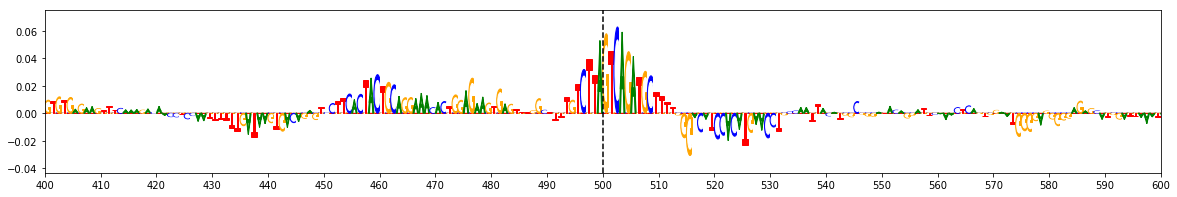

Effect Allele : G   ||   Explain Score : 0.2806   ||   Center / 200bp : 0.3455
Effect Sequence : TTTTGTCTTGGTCAGATGCT


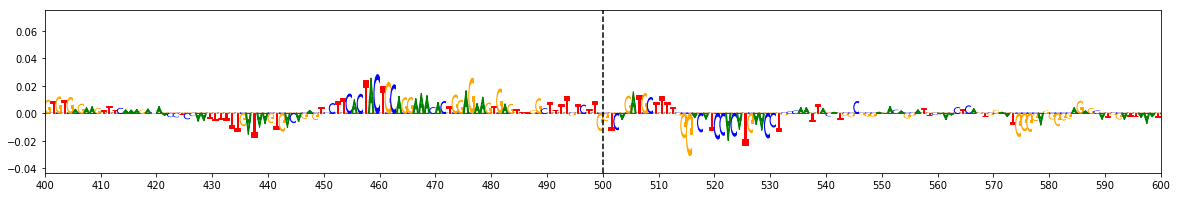

Allele Ratio : 0.3709   ||   Allele Difference : -0.5169  ||  ISM Score : -0.8155  ||  deltaSVM Score : -4.6112


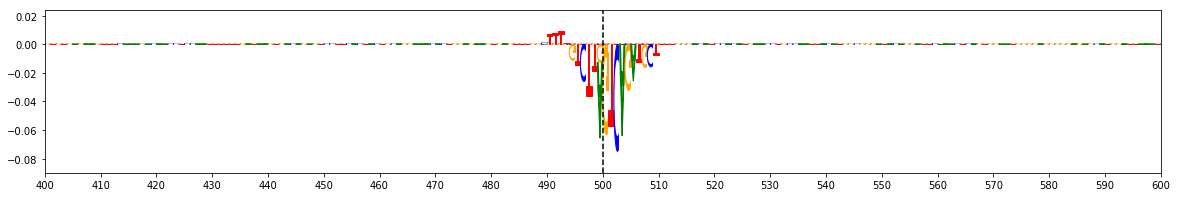


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 418   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.8394   ||   Center / 200bp : 0.711
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


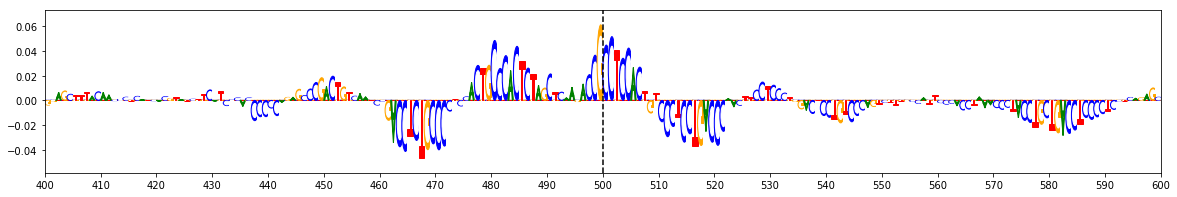

Effect Allele : C   ||   Explain Score : 0.3951   ||   Center / 200bp : 0.5395
Effect Sequence : CTCAAGACCCCCTCCACTGT


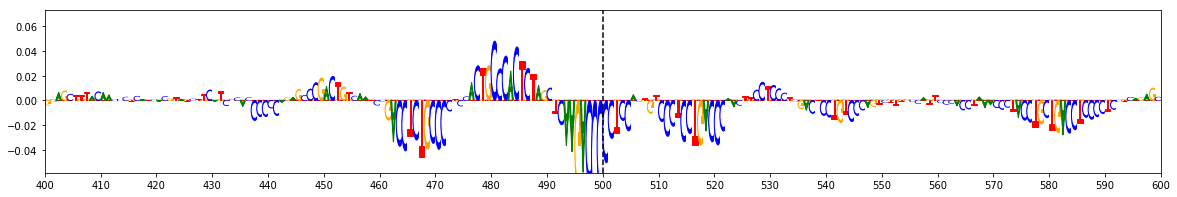

Allele Ratio : 0.4708   ||   Allele Difference : -1.0537  ||  ISM Score : -1.6754  ||  deltaSVM Score : -9.612


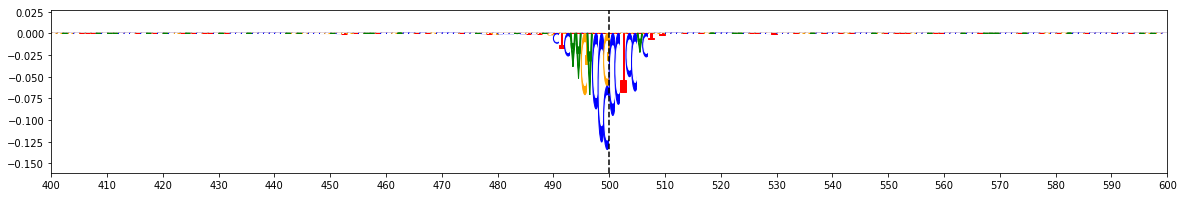


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 583   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.2251   ||   Center / 200bp : 0.5539
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


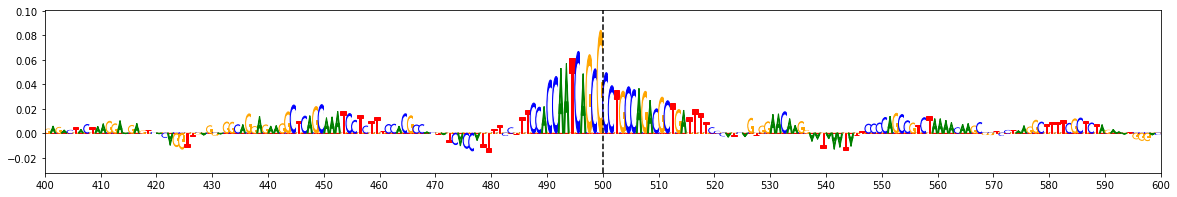

Effect Allele : NAN   ||   Explain Score : 0.469   ||   Center / 200bp : 0.3204
Effect Sequence : CCAATCAGCCCCTGCCAGAC


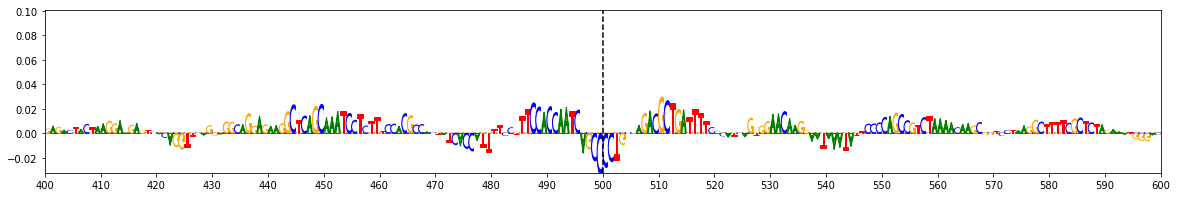

Allele Ratio : 0.3828   ||   Allele Difference : -0.9254  ||  ISM Score : -1.4148  ||  deltaSVM Score : -8.4271


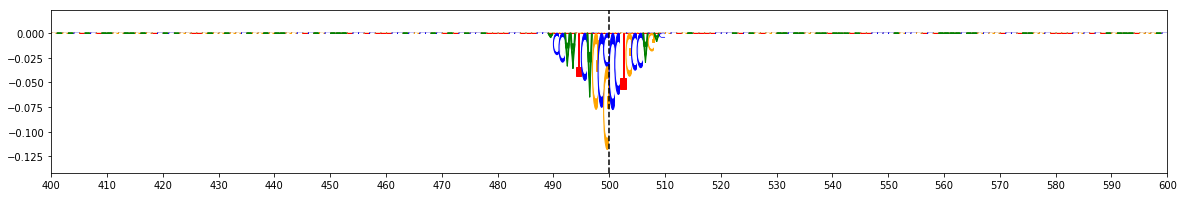


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10514904   ||    chr17 : 46130520 - 46130521   ||    Locus: 304   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.69E-22
Parkinsons_Pankratz_2012 	  4.90E-10

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.8886   ||   Center / 200bp : 0.6796
Noneffect Sequence : TGTAAAAGGCTGTTTCATAC


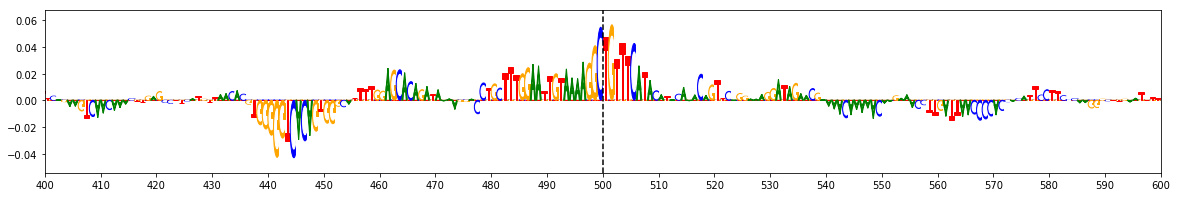

Effect Allele : T   ||   Explain Score : 0.4358   ||   Center / 200bp : 0.5099
Effect Sequence : TGTAAAAGGTTGTTTCATAC


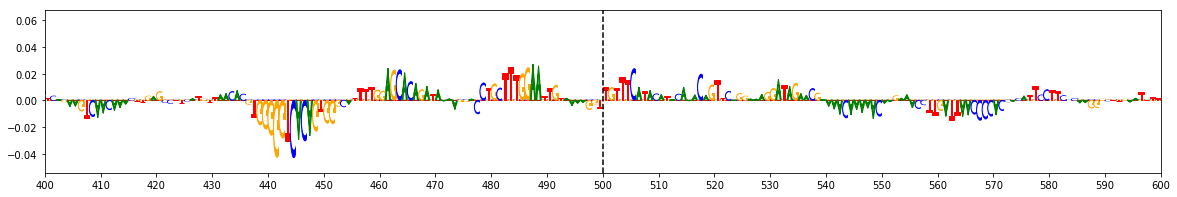

Allele Ratio : 0.4905   ||   Allele Difference : -0.4765  ||  ISM Score : -0.7424  ||  deltaSVM Score : -4.3272


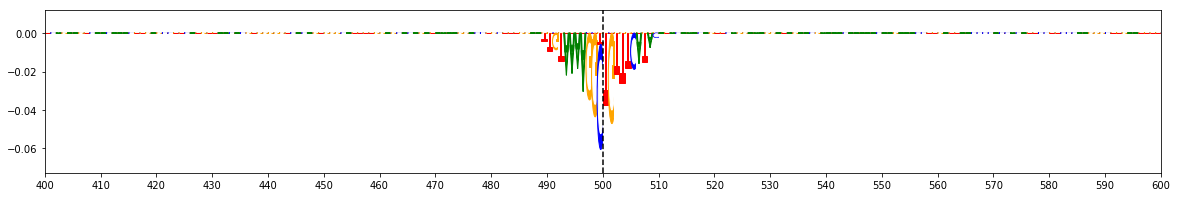


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs35577563   ||    chr19 : 45001090 - 45001091   ||    Locus: 404   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.70E-12
Alzheimers_Kunkle_2019 		  4.76E-09
Alzheimers_Lambert_2013 	  2.68E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.5822   ||   Center / 200bp : 0.5448
Noneffect Sequence : AGAGCCCTGGCAACCTCTCG


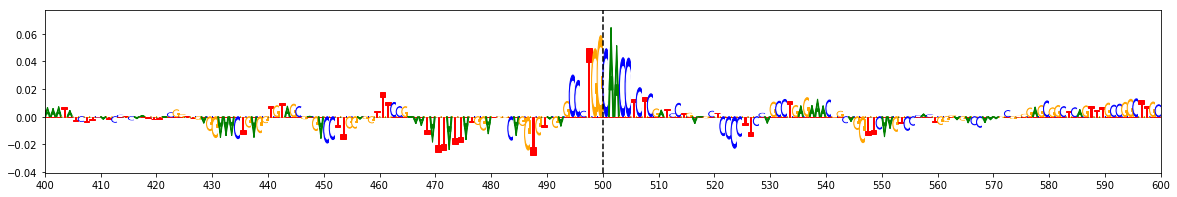

Effect Allele : C   ||   Explain Score : 0.2396   ||   Center / 200bp : 0.3307
Effect Sequence : AGAGCCCTGCCAACCTCTCG


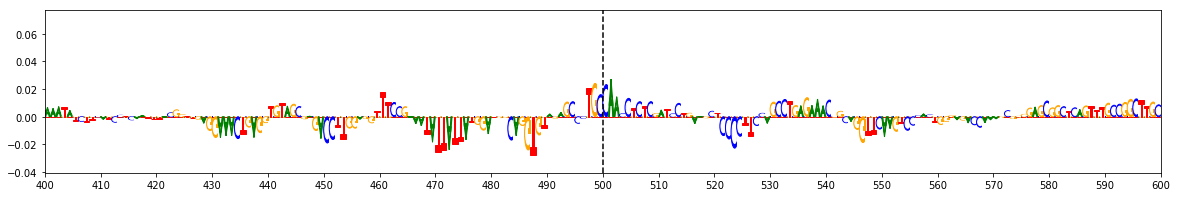

Allele Ratio : 0.4115   ||   Allele Difference : -0.3327  ||  ISM Score : -0.5199  ||  deltaSVM Score : -2.9225


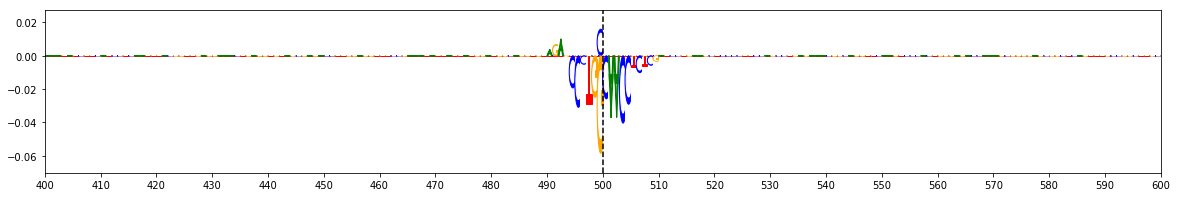


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619361   ||    chr4 : 89836583 - 89836584   ||    Locus: 575   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  2.97E-07
23andme_PD_hg38 		  1.36E-08

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.3011   ||   Center / 200bp : 0.2045
Noneffect Sequence : GTCTCTTTCCTTAGGCTCCC


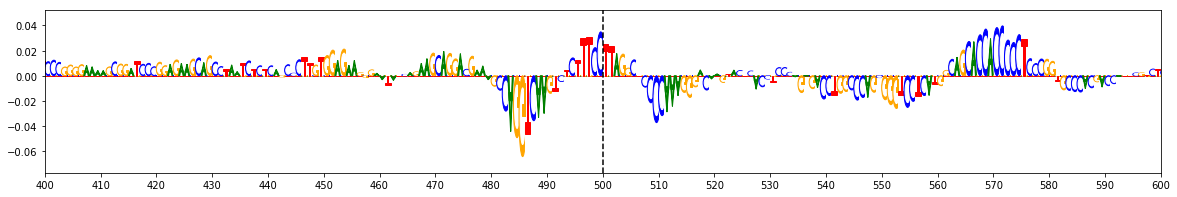

Effect Allele : A   ||   Explain Score : 0.0493   ||   Center / 200bp : 0.0404
Effect Sequence : GTCTCTTTCATTAGGCTCCC


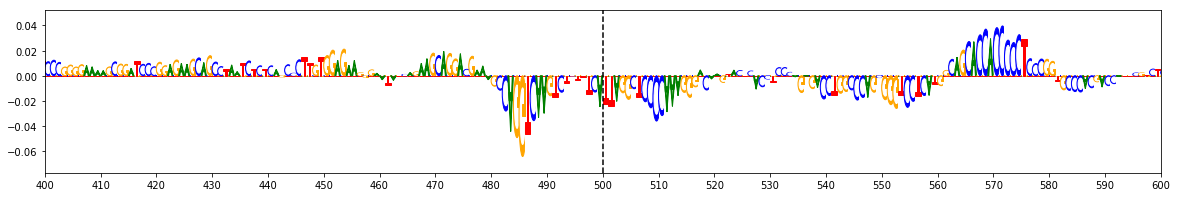

Allele Ratio : 0.1637   ||   Allele Difference : -0.4687  ||  ISM Score : -0.734  ||  deltaSVM Score : -4.1952


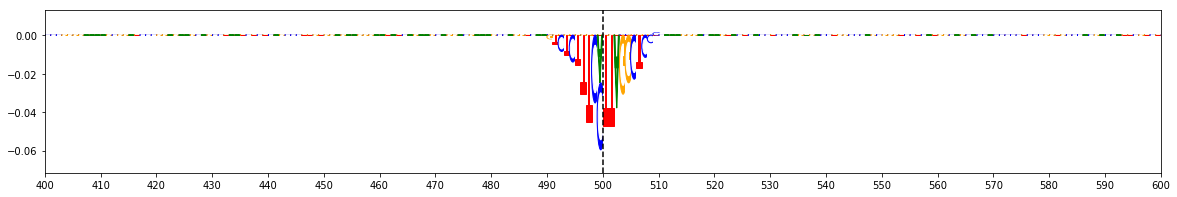


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2737022   ||    chr4 : 89818510 - 89818511   ||    Locus: 567   ||    IDR Peak: False

GWAS:
Parkinsons_Pankratz_2012 	  1.53E-07
23andme_PD_hg38 		  5.13E-09

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.3744   ||   Center / 200bp : 0.3604
Noneffect Sequence : GCTCTCTAACACTCCAGAAA


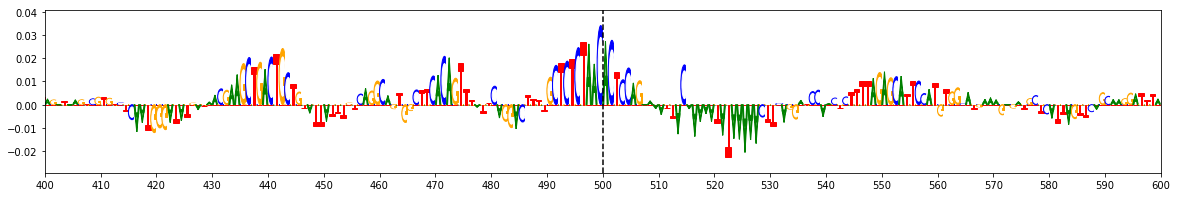

Effect Allele : A   ||   Explain Score : 0.1097   ||   Center / 200bp : 0.1421
Effect Sequence : GCTCTCTAAAACTCCAGAAA


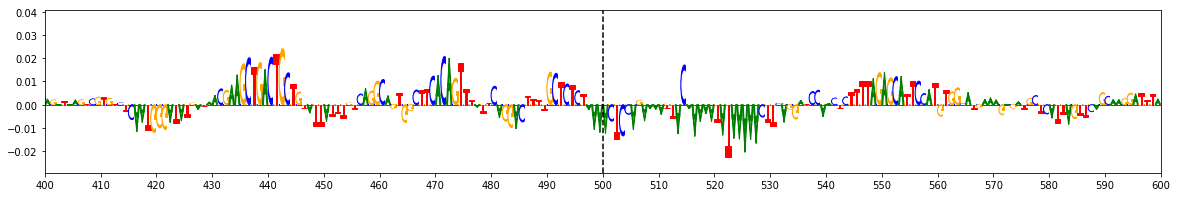

Allele Ratio : 0.2931   ||   Allele Difference : -0.3604  ||  ISM Score : -0.5624  ||  deltaSVM Score : -3.2222


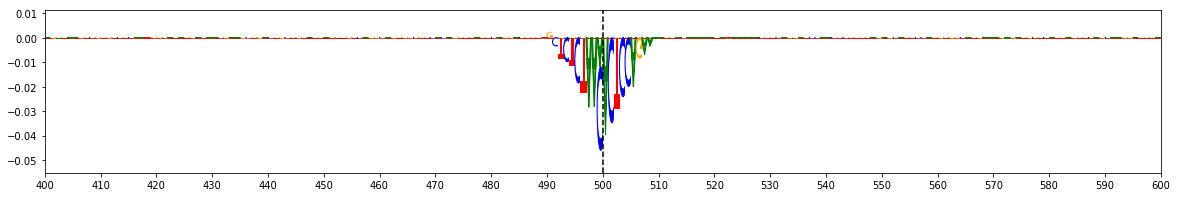


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755951   ||    chr8 : 27369272 - 27369273   ||    Locus: 629   ||    IDR Peak: True

GWAS:
Alzheimers_Lambert_2013 	  1.99E-07
Alzheimers_Jansen_2018 		  1.31E-11
Alzheimers_Kunkle_2019 		  3.79E-08

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.6218   ||   Center / 200bp : 0.6703
Noneffect Sequence : TTCACTGGCCTGTAGGGGGA


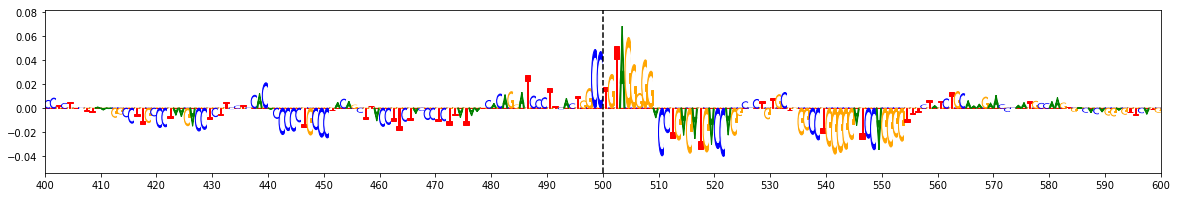

Effect Allele : A   ||   Explain Score : 0.3965   ||   Center / 200bp : 0.5644
Effect Sequence : TTCACTGGCATGTAGGGGGA


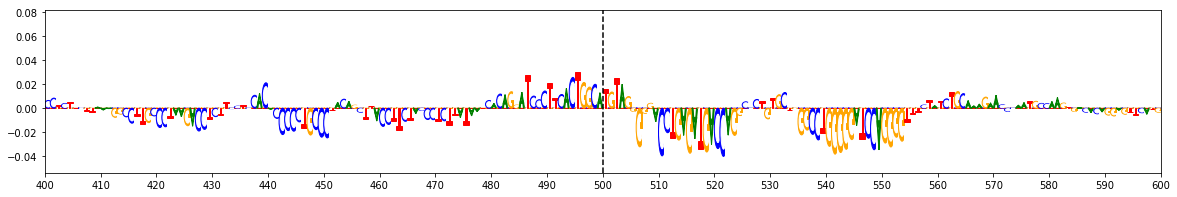

Allele Ratio : 0.6376   ||   Allele Difference : -0.2676  ||  ISM Score : -0.4178  ||  deltaSVM Score : -2.4007


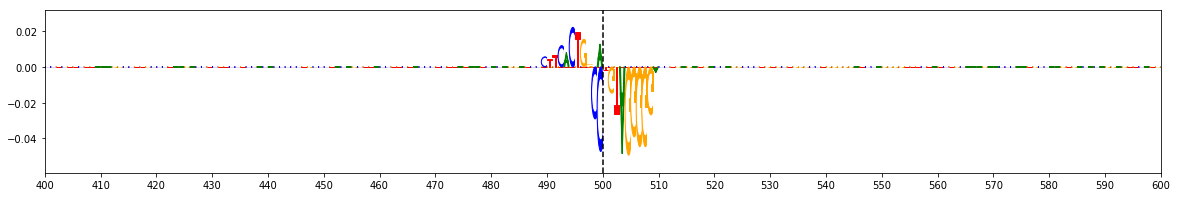


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575896   ||    chr17 : 45894775 - 45894776   ||    Locus: 231   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.8864   ||   Center / 200bp : 0.6023
Noneffect Sequence : GCAGACTGGAGCTTCGTGCG


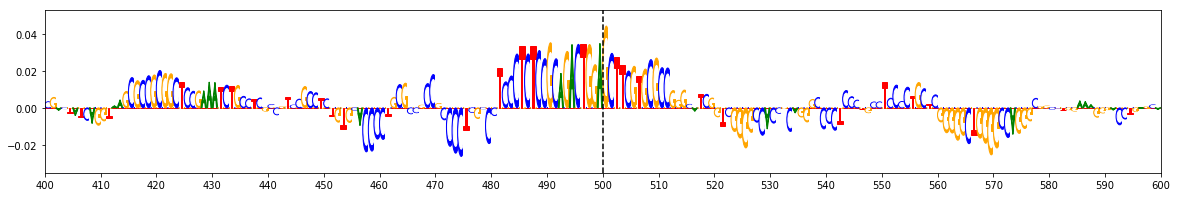

Effect Allele : G   ||   Explain Score : 0.5346   ||   Center / 200bp : 0.4776
Effect Sequence : GCAGACTGGGGCTTCGTGCG


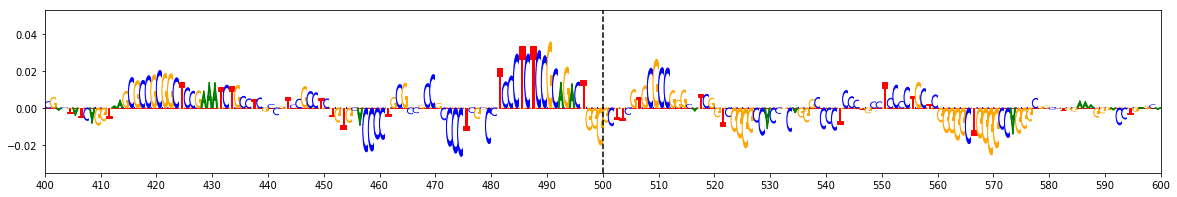

Allele Ratio : 0.6031   ||   Allele Difference : -0.4286  ||  ISM Score : -0.6884  ||  deltaSVM Score : -3.9274


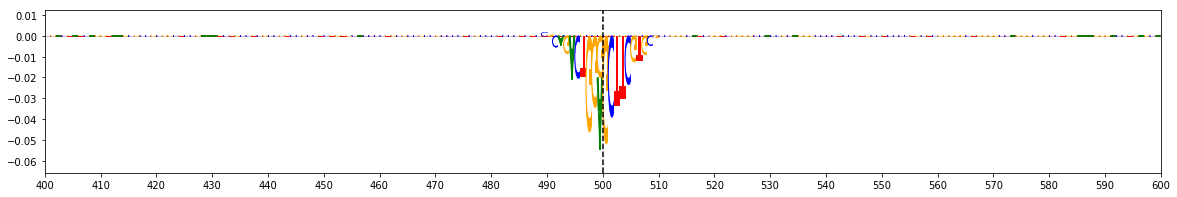


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs56118506   ||    chr3 : 122458998 - 122458999   ||    Locus: 498   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  5.45E-04

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.9299   ||   Center / 200bp : 0.5378
Noneffect Sequence : TTATCACTTCCGGAGGAATC


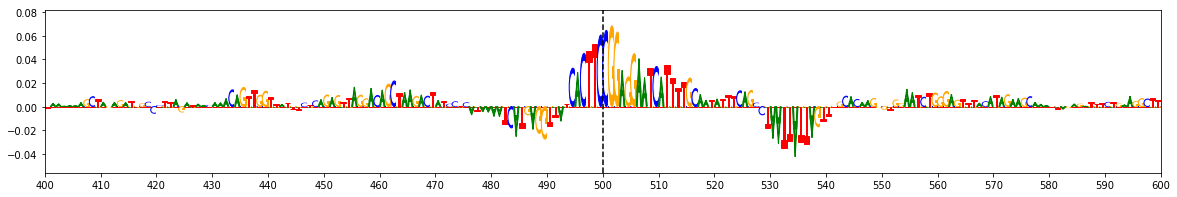

Effect Allele : T   ||   Explain Score : 0.5252   ||   Center / 200bp : 0.3967
Effect Sequence : TTATCACTTTCGGAGGAATC


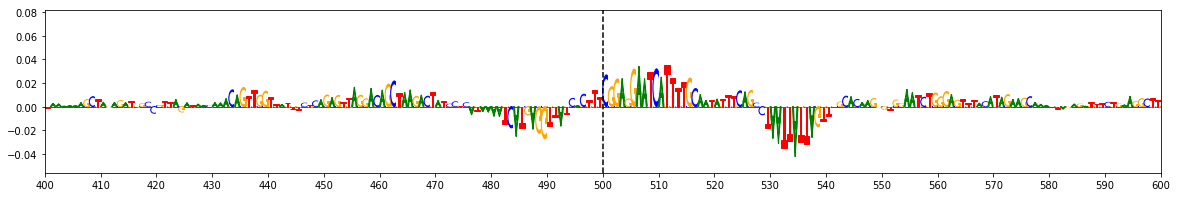

Allele Ratio : 0.5648   ||   Allele Difference : -0.4153  ||  ISM Score : -0.6476  ||  deltaSVM Score : -3.7089


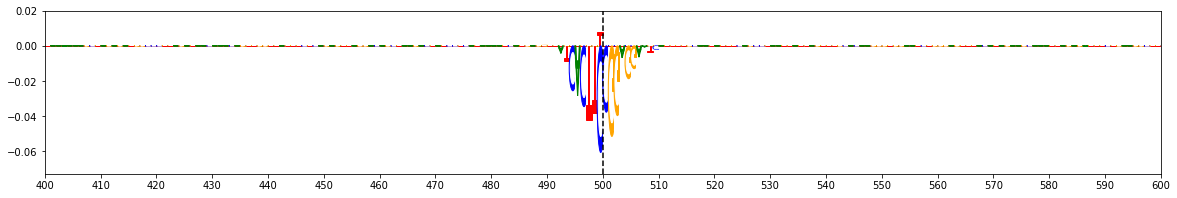


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs73411920   ||    chr11 : 10516033 - 10516034   ||    Locus: 23   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  8.10E-05

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 0.9571   ||   Center / 200bp : 0.4524
Noneffect Sequence : CATCTCTCAGTGAAATCTGG


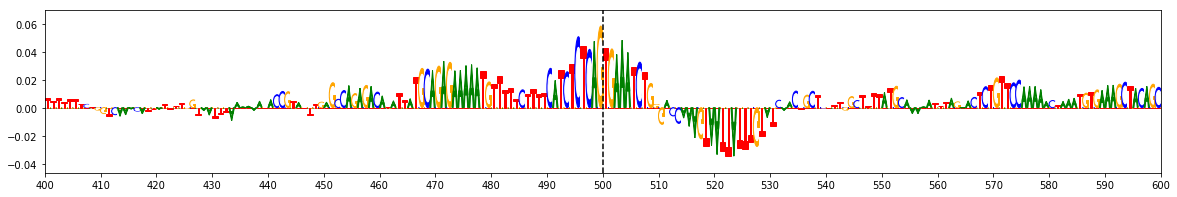

Effect Allele : T   ||   Explain Score : 0.4678   ||   Center / 200bp : 0.2876
Effect Sequence : CATCTCTCATTGAAATCTGG


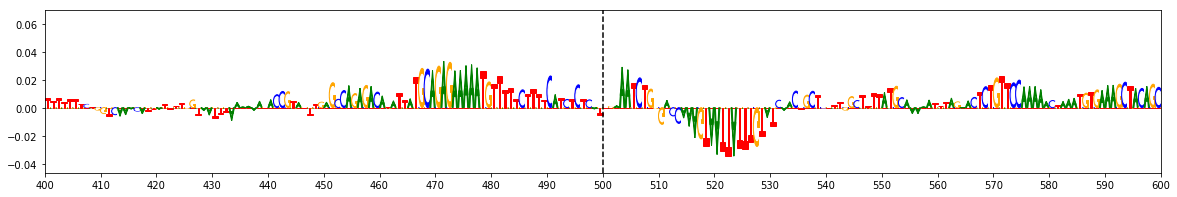

Allele Ratio : 0.4888   ||   Allele Difference : -0.496  ||  ISM Score : -0.7864  ||  deltaSVM Score : -4.5273


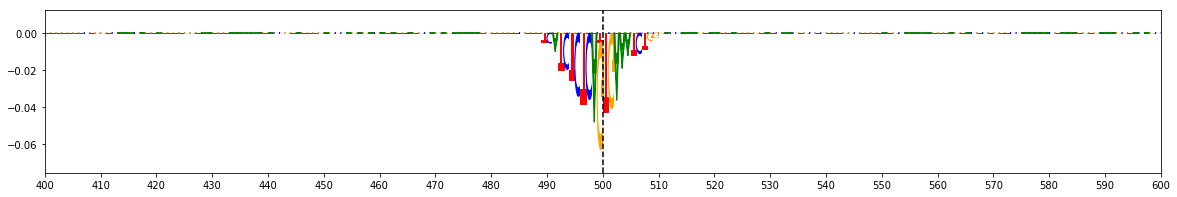


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62063292   ||    chr17 : 45966269 - 45966270   ||    Locus: 276   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.30E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 1.2083   ||   Center / 200bp : 0.5989
Noneffect Sequence : AAAACTGTTCCAAAATAACA


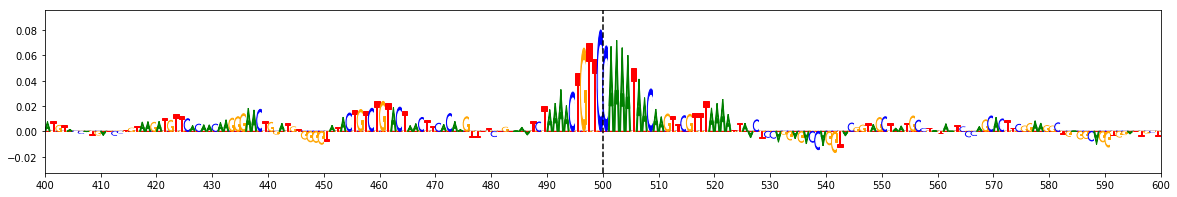

Effect Allele : T   ||   Explain Score : 0.8073   ||   Center / 200bp : 0.5003
Effect Sequence : AAAACTGTTTCAAAATAACA


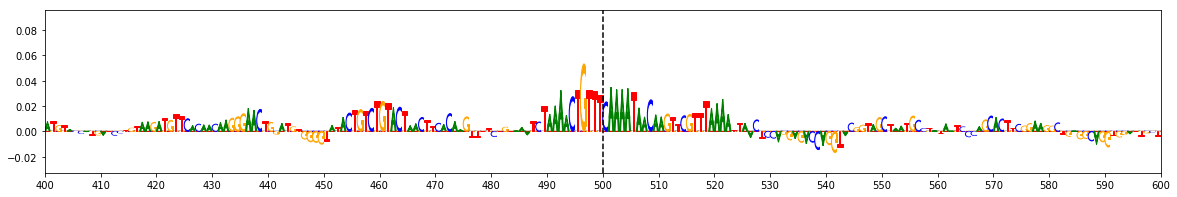

Allele Ratio : 0.6681   ||   Allele Difference : -0.4009  ||  ISM Score : -0.6248  ||  deltaSVM Score : -3.5662


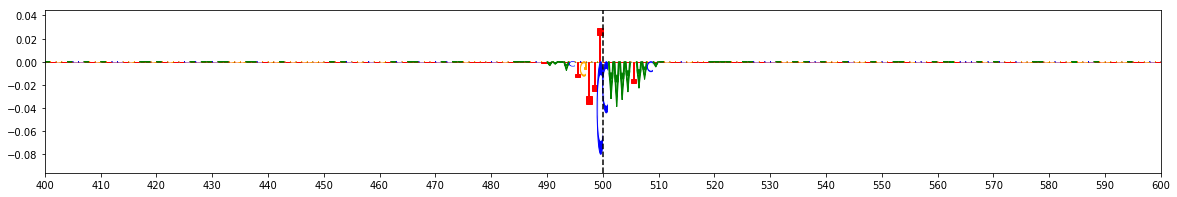


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1388597   ||    chr12 : 40224294 - 40224295   ||    Locus: 68   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.37E-03

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.8975   ||   Center / 200bp : 0.6693
Noneffect Sequence : CTCACAGGGAAACAATGTTT


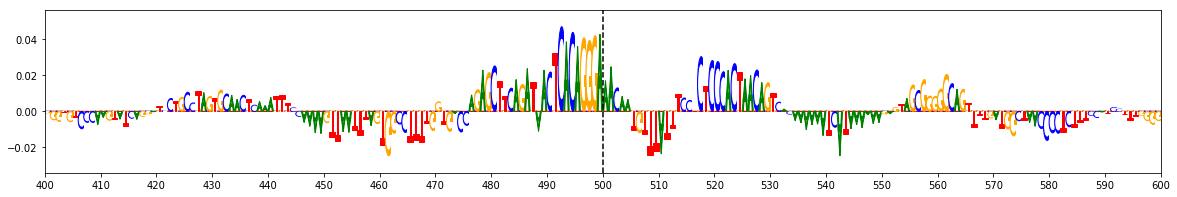

Effect Allele : G   ||   Explain Score : 0.6813   ||   Center / 200bp : 0.6052
Effect Sequence : CTCACAGGGGAACAATGTTT


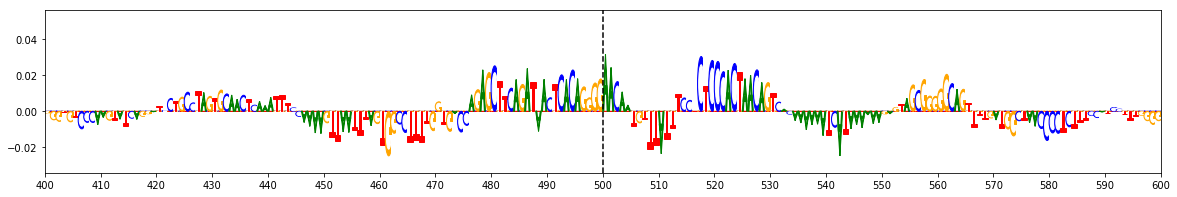

Allele Ratio : 0.759   ||   Allele Difference : -0.1937  ||  ISM Score : -0.2996  ||  deltaSVM Score : -1.8192


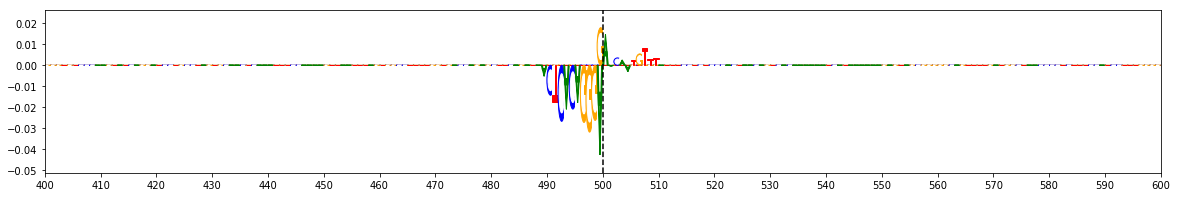


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426750   ||    chr19 : 44954426 - 44954427   ||    Locus: 388   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.01E-09
Alzheimers_Kunkle_2019 		  1.76E-13
Alzheimers_Lambert_2013 	  2.77E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.7191   ||   Center / 200bp : 0.5053
Noneffect Sequence : TCTAAAAAAGAAAAAAAAAG


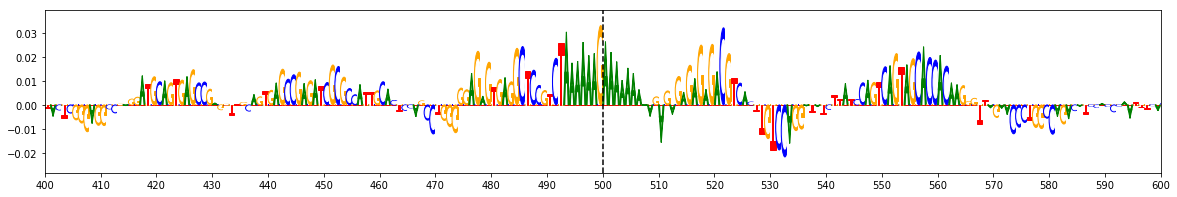

Effect Allele : C   ||   Explain Score : 0.415   ||   Center / 200bp : 0.3707
Effect Sequence : TCTAAAAAACAAAAAAAAAG


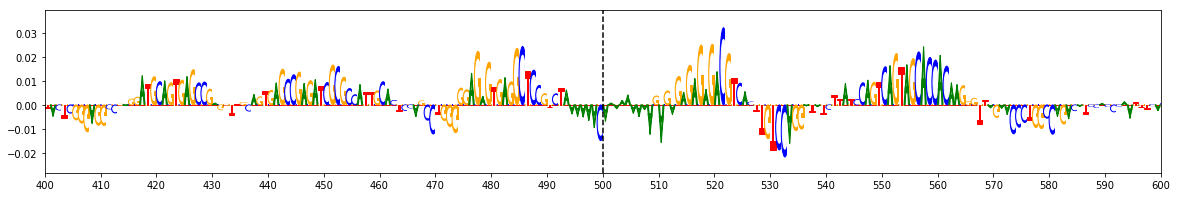

Allele Ratio : 0.5771   ||   Allele Difference : -0.376  ||  ISM Score : -0.5775  ||  deltaSVM Score : -3.8559


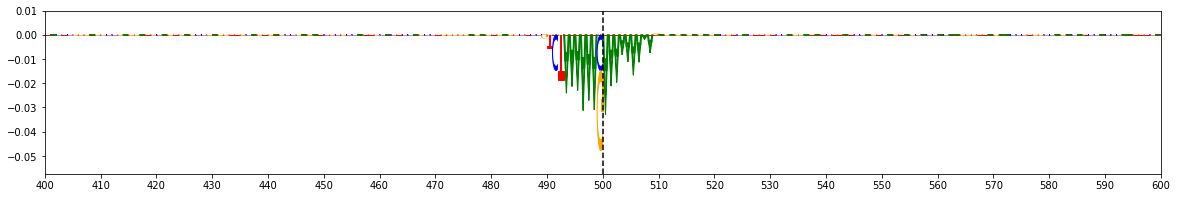


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79589869   ||    chr17 : 45852871 - 45852872   ||    Locus: 223   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.11E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 3.637   ||   Center / 200bp : 0.8245
Noneffect Sequence : TTGAATGCTACTGTGCTGCC


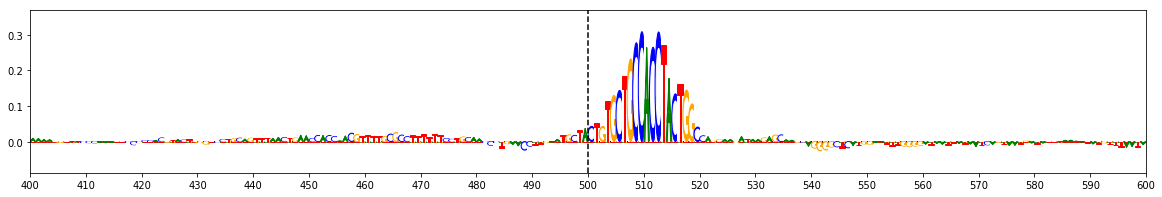

Effect Allele : C   ||   Explain Score : 3.4641   ||   Center / 200bp : 0.8173
Effect Sequence : TTGAATGCTCCTGTGCTGCC


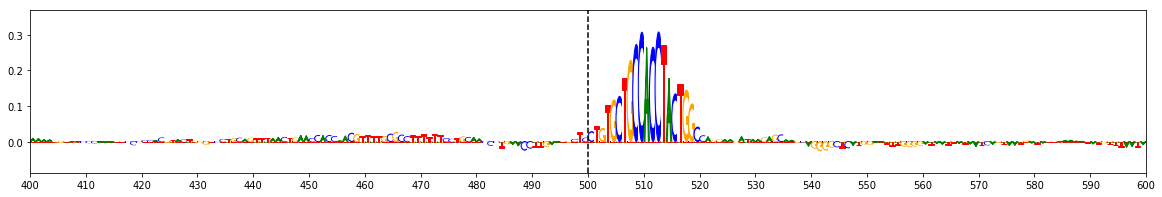

Allele Ratio : 0.9525   ||   Allele Difference : -0.2176  ||  ISM Score : -0.3411  ||  deltaSVM Score : -1.9994


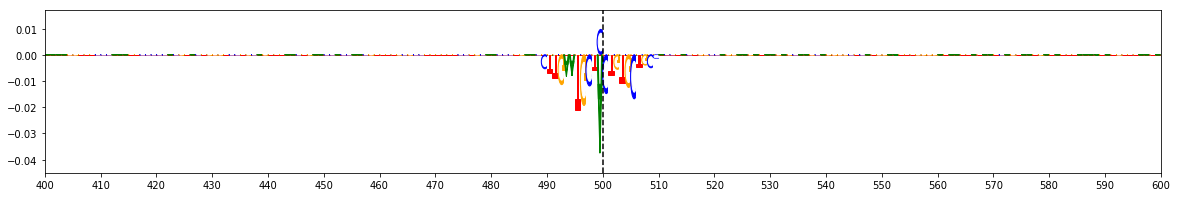


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 363   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.718   ||   Center / 200bp : 0.3917
Noneffect Sequence : CAACACGGGGCGGGCACAAG


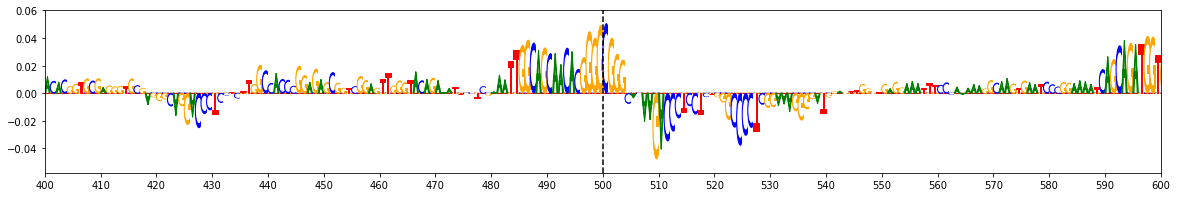

Effect Allele : T   ||   Explain Score : 0.3313   ||   Center / 200bp : 0.2287
Effect Sequence : CAACACGGGTCGGGCACAAG


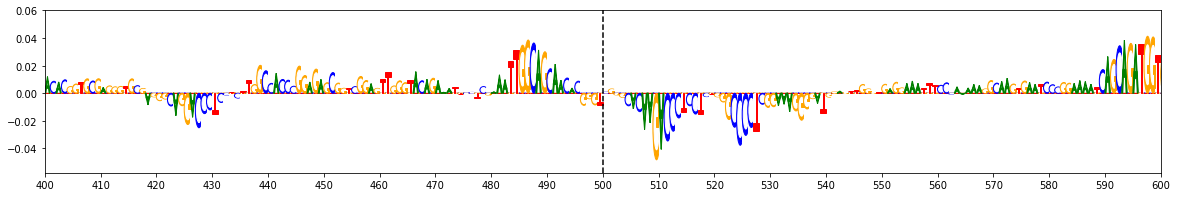

Allele Ratio : 0.4614   ||   Allele Difference : -0.4527  ||  ISM Score : -0.7218  ||  deltaSVM Score : -4.1569


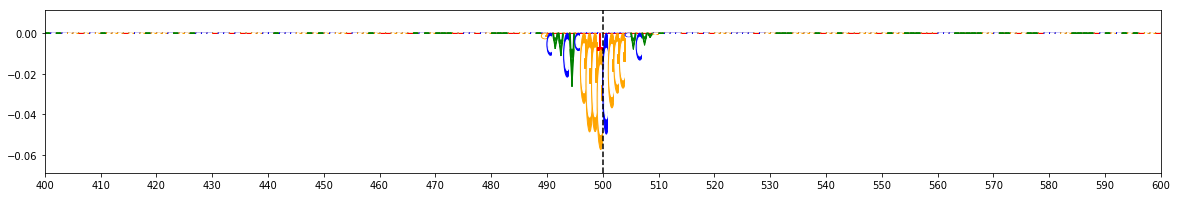


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3733345   ||    chr4 : 960458 - 960459   ||    Locus: 513   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.35E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.2219   ||   Center / 200bp : 0.6273
Noneffect Sequence : GATGAGGGCGGGTCCCGCTC


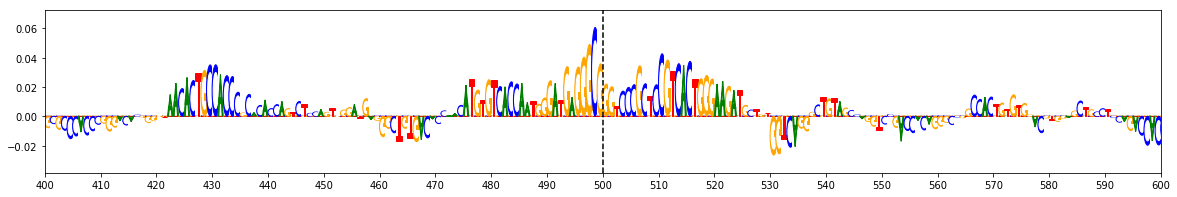

Effect Allele : T   ||   Explain Score : 0.9157   ||   Center / 200bp : 0.5602
Effect Sequence : GATGAGGGCTGGTCCCGCTC


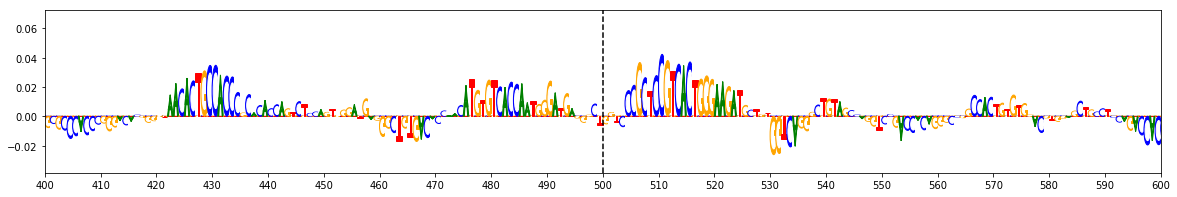

Allele Ratio : 0.7494   ||   Allele Difference : -0.3339  ||  ISM Score : -0.5125  ||  deltaSVM Score : -2.9717


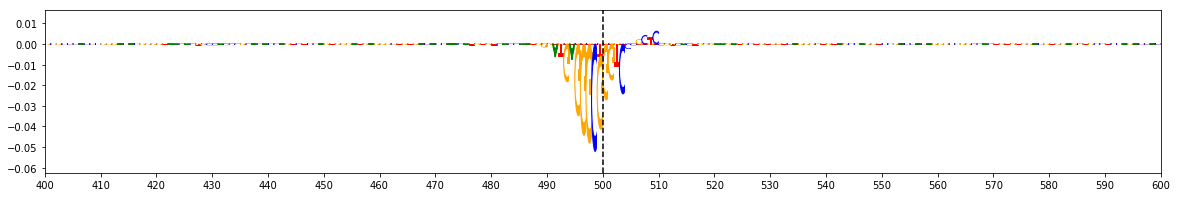


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7681312   ||    chr4 : 89717375 - 89717376   ||    Locus: 536   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  9.70E-19

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.7589   ||   Center / 200bp : 0.4002
Noneffect Sequence : TGTATGTTTCAGTGCTTTGA


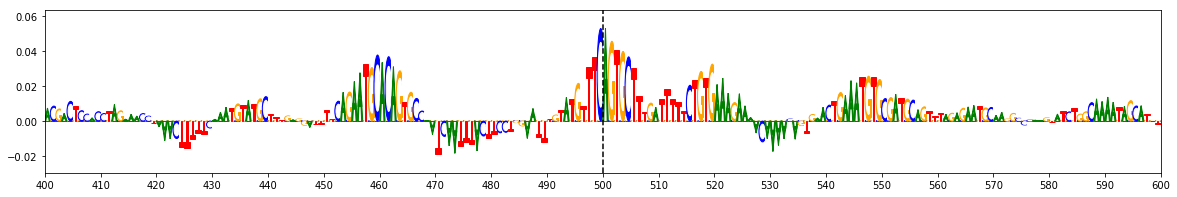

Effect Allele : G   ||   Explain Score : 0.3651   ||   Center / 200bp : 0.2427
Effect Sequence : TGTATGTTTGAGTGCTTTGA


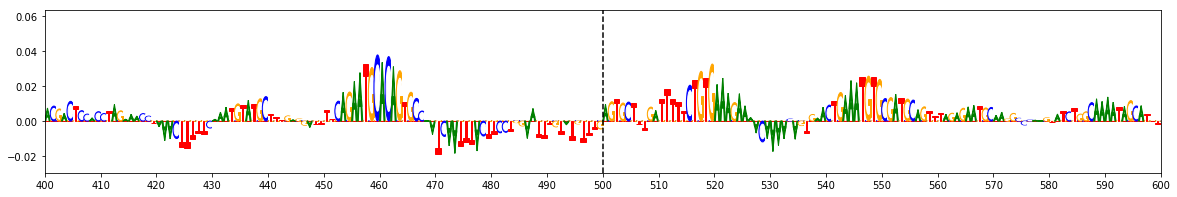

Allele Ratio : 0.481   ||   Allele Difference : -0.4548  ||  ISM Score : -0.7113  ||  deltaSVM Score : -4.1023


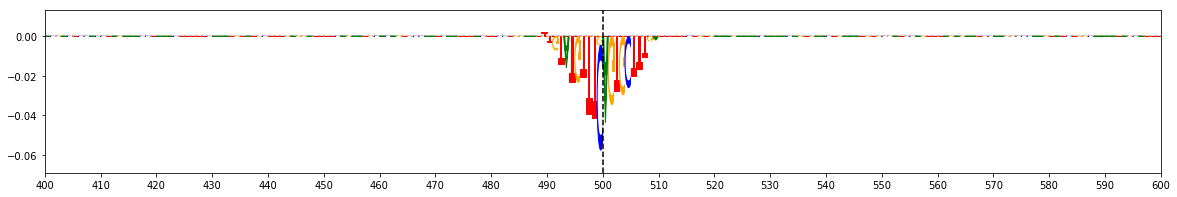


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect   ref    alt  \
270  chr17   45959712   45959713  rs113793114      G         A     G      A   
318  chr17   46213482   46213483   rs76475191      T         A     T      A   
240  chr17   45896863   45896864   rs62056782      T         C     C      T   
494   chr3   52498433   52498434  rs181391313      G         A     G      A   
222  chr17   45852666   45852667   rs62054825      G         A     G      A   
294  chr17   46038519   46038520   rs12150090      T         C     C    G,T   
459   chr2  134719288  134719289   rs62171396      T         C     C      T   
431   chr2   95336902   95336903    rs6741001      G         A     A    G,T   
18   chr10   80493944   80493945    rs7900536      A         C     C    A,T   
430   chr2   95324017   95324018    rs3772034      G         A     G      A   
587   chr4   90290372   90290373   rs75541595      G         A     G      A   
275  chr17   45966011   45966012   rs62063291      T         C     T      C   
106  chr16   31011317   31011318   rs72800847      G         A     G      A   
1     chr1  154865462  154865463  rs116839452      G         A     A      G   
550   chr4   89762970   89762971   rs34806123      G         A     A      G   
596   chr5  134594466  134594467  rs113661575      G         C     G    A,C   
105  chr16   31009756   31009757    rs7184567      T         C     C      T   
199  chr17   45742017   45742018   rs62054424      G         A     G      A   
381  chr19   44911193   44911194     rs439401      T         C     T      C   
43   chr11   60251687   60251688     rs636341      A         C     A      C   
408  chr19   45039212   45039213   rs34034621      T         C     C      T   
539   chr4   89723193   89723194   rs79596632      G         A     G      A   
626   chr8   22673949   22673950   rs11985023      T         C     C      T   
499   chr3  122459017  122459018   rs55793255      G         A     A      G   
387  chr19   44954309   44954310    rs7245611      C         T     T    C,G   
588   chr5  102959365  102959366    rs3776870      G         A     G      A   
242  chr17   45897109   45897110   rs80346216      T         G     G      T   
317  chr17   46213392   46213393    rs2668662      T         C     T      C   
420   chr2   95076932   95076933    rs3105101      C         A     C      A   
227  chr17   45894114   45894115   rs80233201      T         C     T      C   
..     ...        ...        ...          ...    ...       ...   ...    ...   
31   chr11   47426945   47426946   rs11600581      T         C     T    A,C   
607   chr6  132812798  132812799   rs79333841      G         C     C    G,T   
516   chr4     968130     968131   rs62294486      T         C     C    A,T   
241  chr17   45896987   45896988  rs113161176      G         A     G      A   
248  chr17   45908295   45908296   rs79290980      T         C     T      C   
383  chr19   44915532   44915533       rs5117      C         T     T      C   
371  chr19   44758447   44758448   rs34967149      T         C     C      T   
478   chr3   48948965   48948966   rs13315711      T         A     A      T   
553   chr4   89766355   89766356    rs3796661      T         C     C      T   
16   chr10   80491787   80491788    rs7922621      A         C     C      A   
74   chr12  122836031  122836032   rs12820345      T         G     G      T   
284  chr17   46002200   46002201   rs17573447      T         C     C      T   
382  chr19   44915228   44915229   rs12691088      A         G     G    A,C   
547   chr4   89753299   89753300    rs3756054      T         C     T      C   
280  chr17   45997246   45997247   rs62063853      G         A     A      G   
260  chr17   45949111   45949112   rs78556223      G         A     A      G   
606   chr6   47477280   47477281    rs1004173      T         C     C      T   
159  chr17   45664085   45664086   rs17760577      T         C     C      T   
301  chr17   46052633   46052634  rs142767245      I     

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs113793114   ||    chr17 : 45959712 - 45959713   ||    Locus: 270   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.58E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.1281   ||  Center / 200bp: 0.8957
Effect Sequence: CAAGGAGGCGGAGGTTTCAG


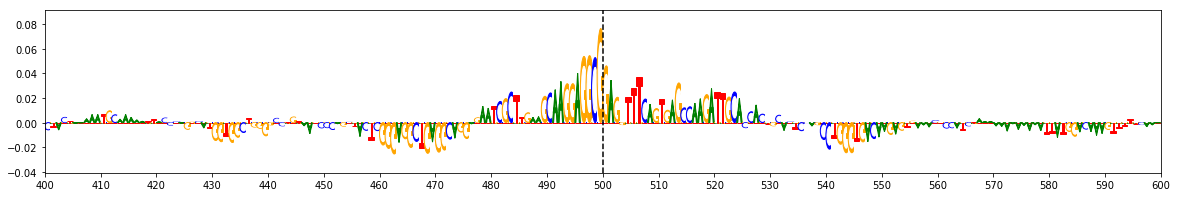

Noneffect Allele: A   ||  Explain Score: 0.5725   ||  Center / 200bp: 0.8134
Noneffect Sequence: CAAGGAGGCAGAGGTTTCAG


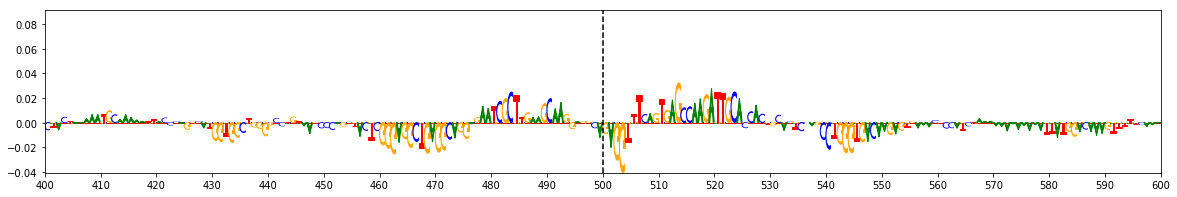

Allele Ratio : 1.9705   ||   Allele Difference : 0.6911  ||  ISM Score : 1.093  ||  deltaSVM Score : 6.3095


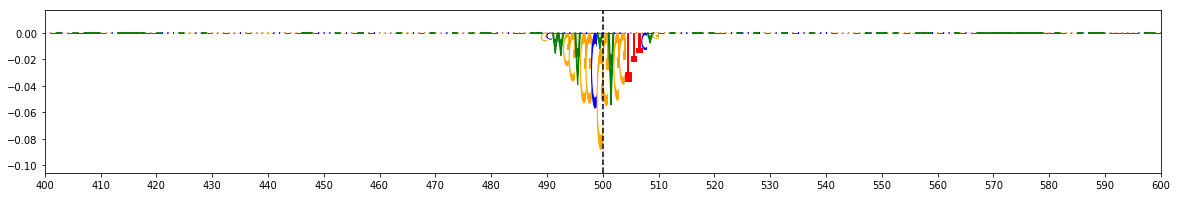


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs76475191   ||    chr17 : 46213482 - 46213483   ||    Locus: 318   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.10E-18

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.3791   ||  Center / 200bp: 0.5659
Effect Sequence: TTTTTTTTTTTTTTTTAGTA


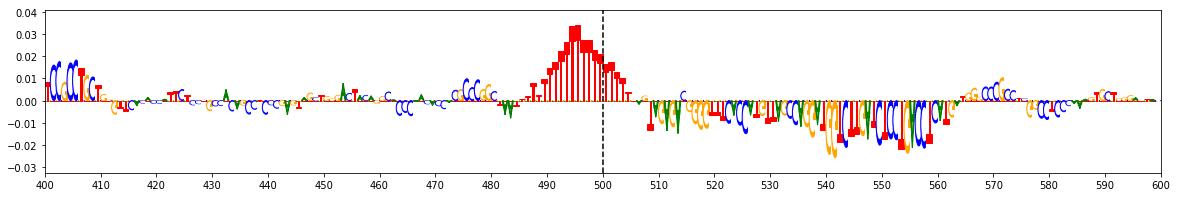

Noneffect Allele: A   ||  Explain Score: 0.1232   ||  Center / 200bp: 0.2419
Noneffect Sequence: TTTTTTTTTATTTTTTAGTA


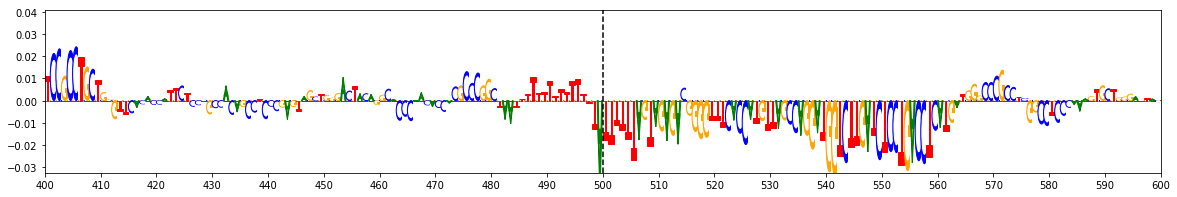

Allele Ratio : 3.0763   ||   Allele Difference : 0.5077  ||  ISM Score : 0.6252  ||  deltaSVM Score : 15.1143


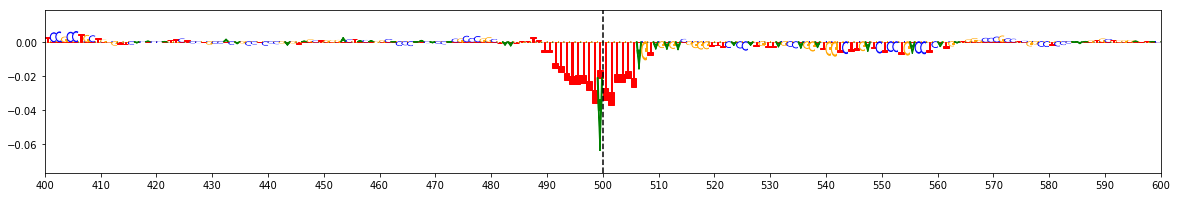


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62056782   ||    chr17 : 45896863 - 45896864   ||    Locus: 240   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.8111   ||  Center / 200bp: 0.7
Effect Sequence: CTCGCCCTCTTGTGATGAAC


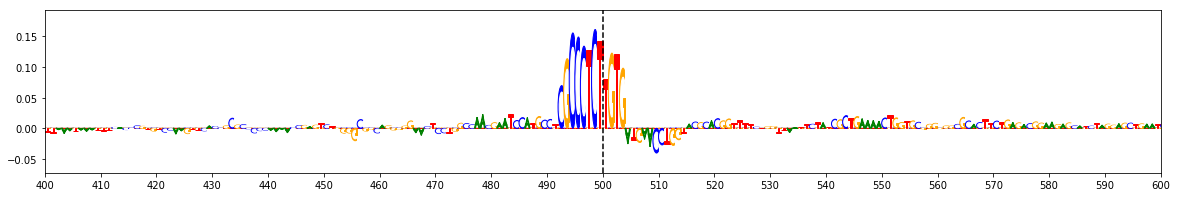

Noneffect Allele: C   ||  Explain Score: 0.8506   ||  Center / 200bp: 0.523
Noneffect Sequence: CTCGCCCTCCTGTGATGAAC


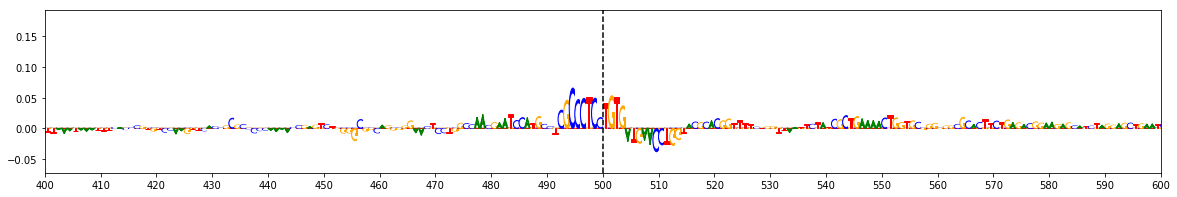

Allele Ratio : 2.1292   ||   Allele Difference : 0.9682  ||  ISM Score : 1.5119  ||  deltaSVM Score : 8.7117


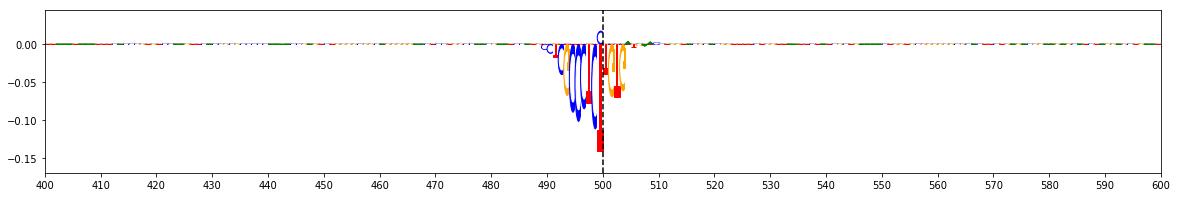


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs181391313   ||    chr3 : 52498433 - 52498434   ||    Locus: 494   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.73E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.3304   ||  Center / 200bp: 0.1894
Effect Sequence: CCATGGGGCGGAGGCAGGGC


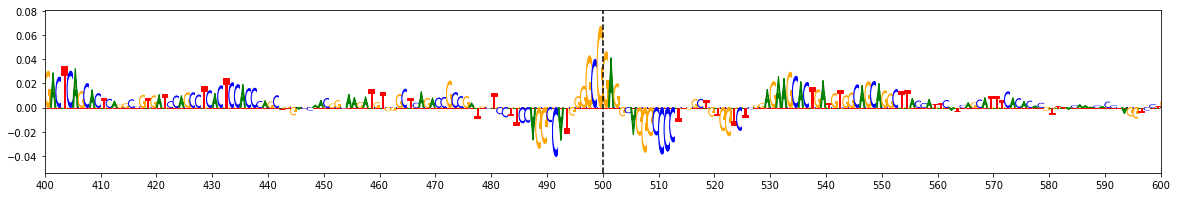

Noneffect Allele: A   ||  Explain Score: 0.0449   ||  Center / 200bp: 0.0308
Noneffect Sequence: CCATGGGGCAGAGGCAGGGC


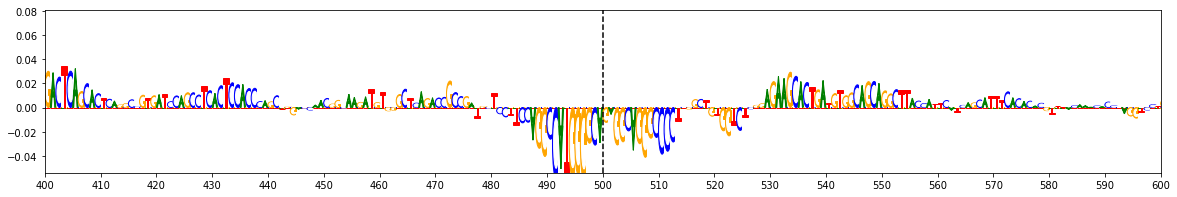

Allele Ratio : 7.3565   ||   Allele Difference : 0.7631  ||  ISM Score : 1.1933  ||  deltaSVM Score : 6.8858


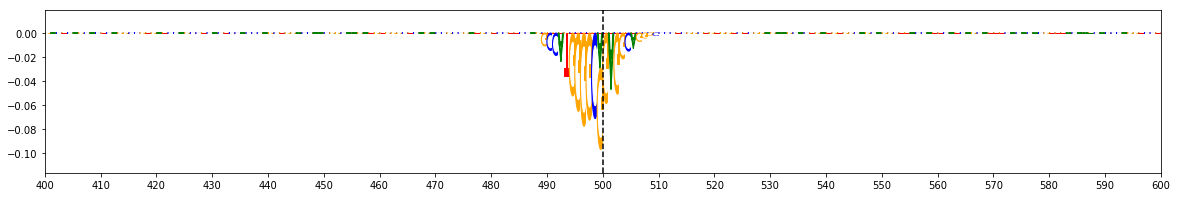


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054825   ||    chr17 : 45852666 - 45852667   ||    Locus: 222   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.25E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.5523   ||  Center / 200bp: 0.604
Effect Sequence: TGAGCTCCCGGAAGTGGAGT


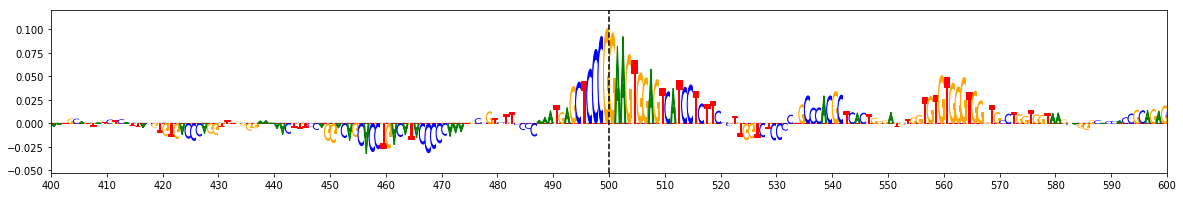

Noneffect Allele: A   ||  Explain Score: 0.7476   ||  Center / 200bp: 0.4233
Noneffect Sequence: TGAGCTCCCAGAAGTGGAGT


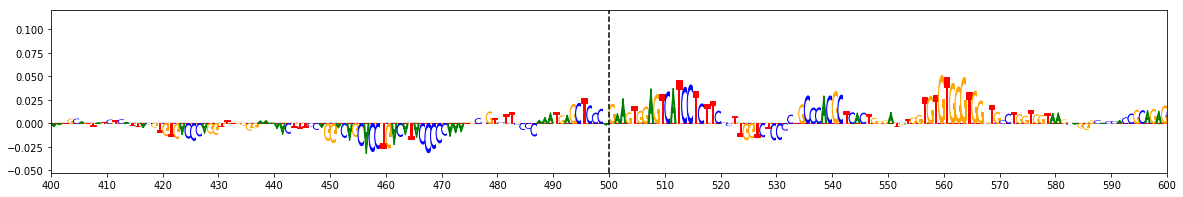

Allele Ratio : 2.0763   ||   Allele Difference : 0.8065  ||  ISM Score : 1.2625  ||  deltaSVM Score : 7.2467


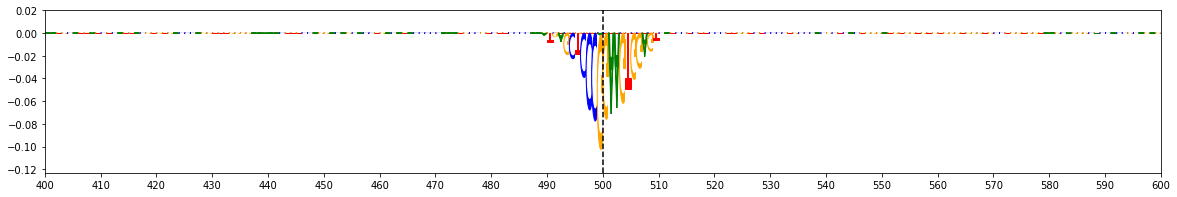


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12150090   ||    chr17 : 46038519 - 46038520   ||    Locus: 294   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.51E-22
Parkinsons_Pankratz_2012 	  4.06E-10

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.9651   ||  Center / 200bp: 0.4235
Effect Sequence: TCCGGCCAATCCCACACAGG


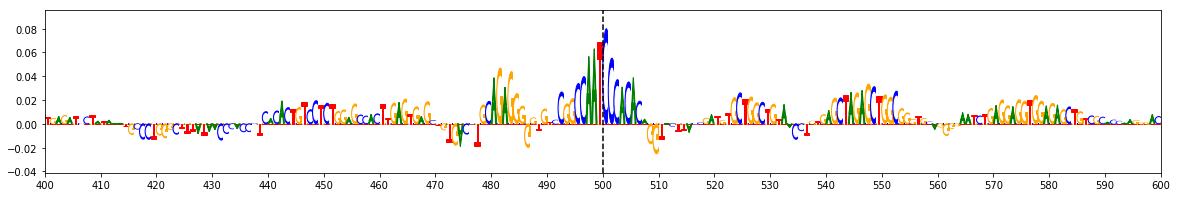

Noneffect Allele: C   ||  Explain Score: 0.3434   ||  Center / 200bp: 0.2076
Noneffect Sequence: TCCGGCCAACCCCACACAGG


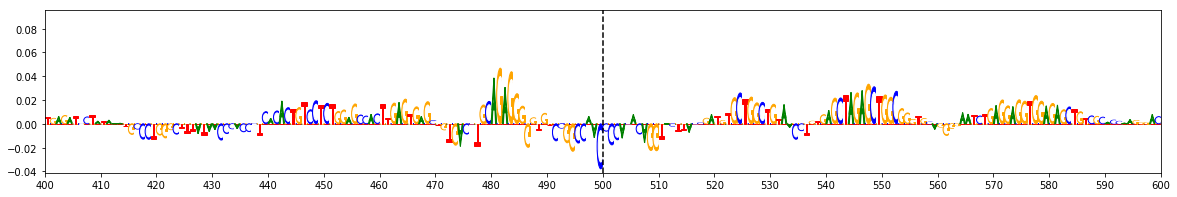

Allele Ratio : 2.8105   ||   Allele Difference : 0.8369  ||  ISM Score : 1.3073  ||  deltaSVM Score : 7.5651


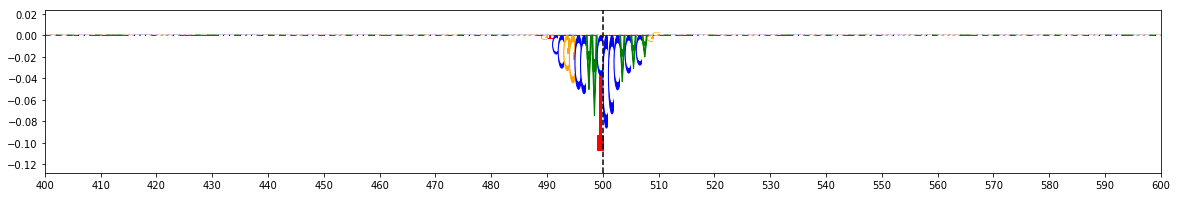


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62171396   ||    chr2 : 134719288 - 134719289   ||    Locus: 459   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.04E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.9324   ||  Center / 200bp: 0.4907
Effect Sequence: ACAGGCGGCTCTGGCAGAGC


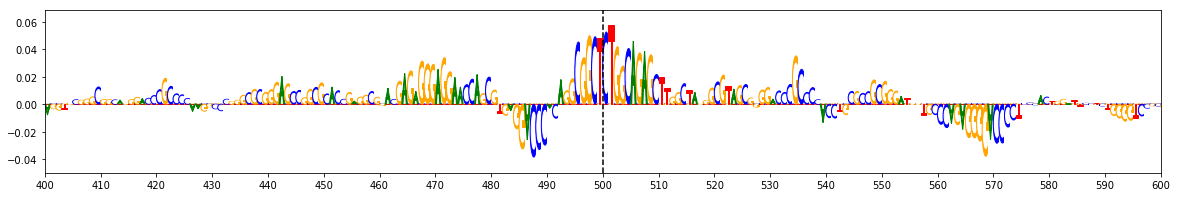

Noneffect Allele: C   ||  Explain Score: 0.4093   ||  Center / 200bp: 0.2962
Noneffect Sequence: ACAGGCGGCCCTGGCAGAGC


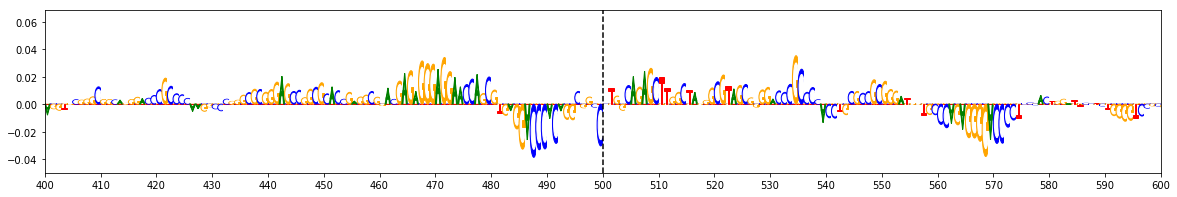

Allele Ratio : 2.2777   ||   Allele Difference : 0.6199  ||  ISM Score : 0.9915  ||  deltaSVM Score : 5.7409


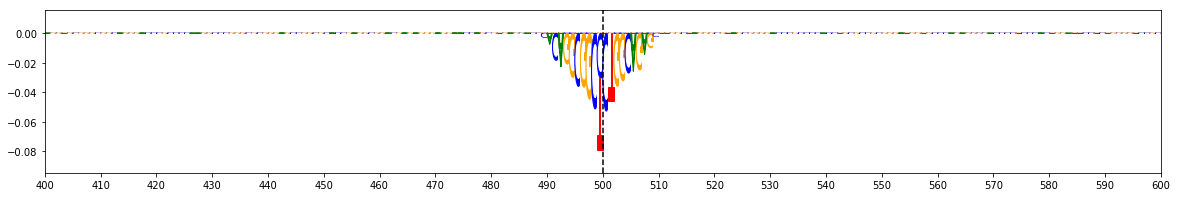


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6741001   ||    chr2 : 95336902 - 95336903   ||    Locus: 431   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.16E-02

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.2017   ||  Center / 200bp: 0.112
Effect Sequence: ATTTCCTCAGTGCTCTCTGA


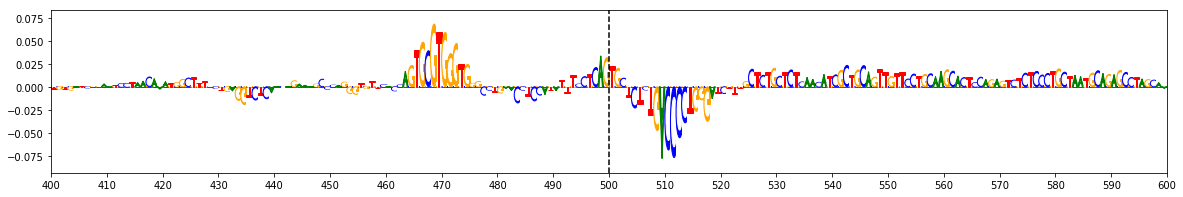

Noneffect Allele: A   ||  Explain Score: 0.0207   ||  Center / 200bp: 0.0128
Noneffect Sequence: ATTTCCTCAATGCTCTCTGA


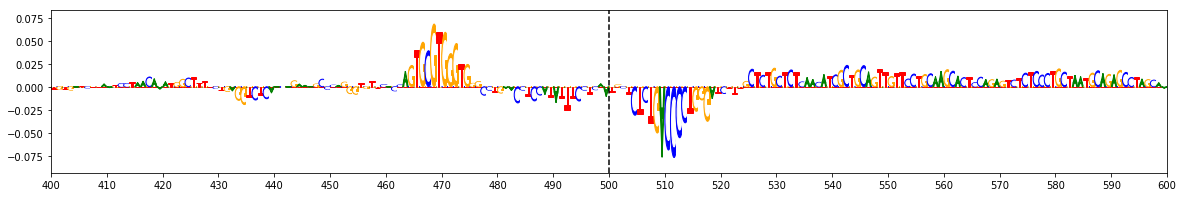

Allele Ratio : 9.744   ||   Allele Difference : 0.3313  ||  ISM Score : 0.517  ||  deltaSVM Score : 3.0353


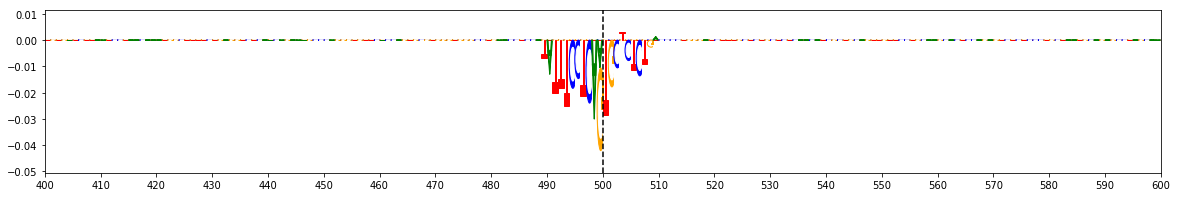


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7900536   ||    chr10 : 80493944 - 80493945   ||    Locus: 18   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  2.91E-05

Coloc:  True

Effect Allele: A   ||  Explain Score: 1.8455   ||  Center / 200bp: 0.6677
Effect Sequence: GGATGATTCAGATAATGTCT


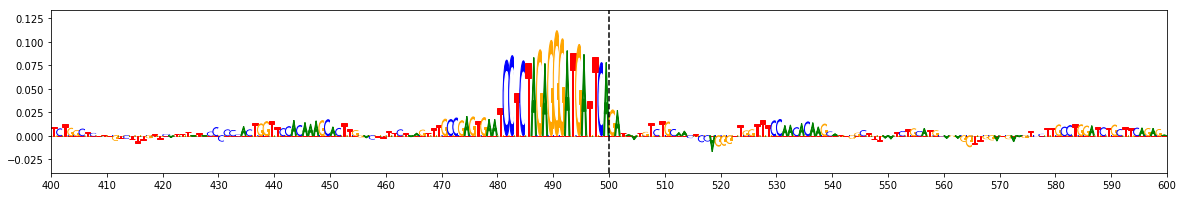

Noneffect Allele: C   ||  Explain Score: 1.2107   ||  Center / 200bp: 0.5685
Noneffect Sequence: GGATGATTCCGATAATGTCT


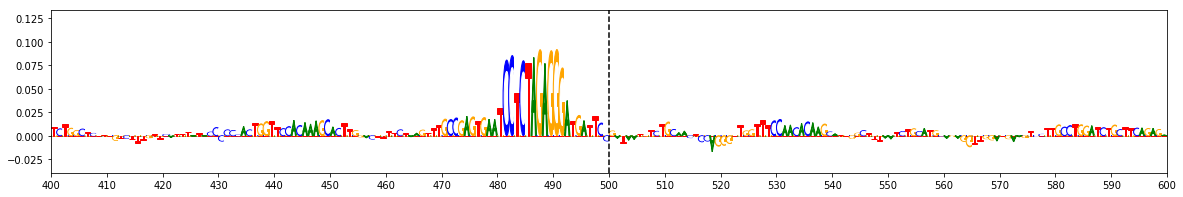

Allele Ratio : 1.5243   ||   Allele Difference : 0.6558  ||  ISM Score : 1.0202  ||  deltaSVM Score : 6.0731


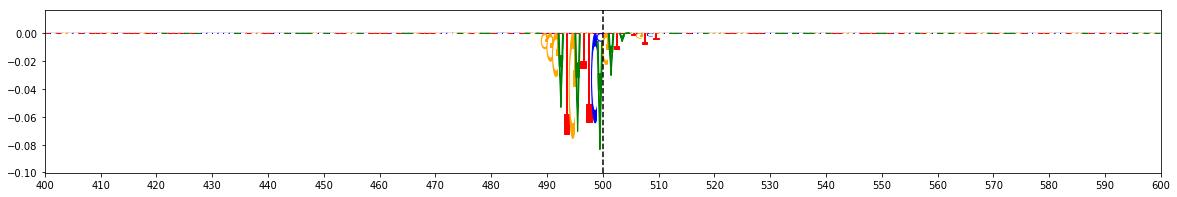


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3772034   ||    chr2 : 95324017 - 95324018   ||    Locus: 430   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  8.12E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 1.1417   ||  Center / 200bp: 0.5165
Effect Sequence: AGGCAGAGGGAGCCCGCGGC


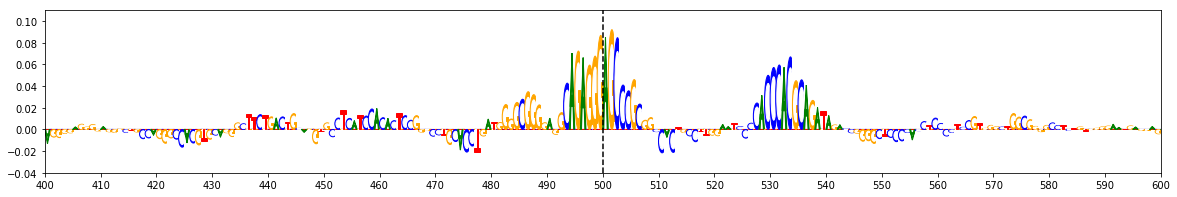

Noneffect Allele: A   ||  Explain Score: 0.5856   ||  Center / 200bp: 0.3537
Noneffect Sequence: AGGCAGAGGAAGCCCGCGGC


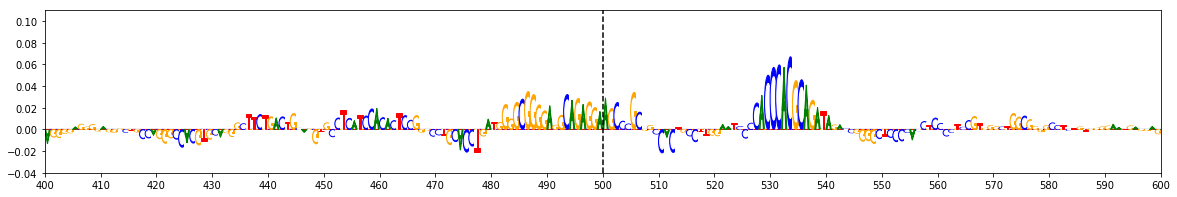

Allele Ratio : 1.9496   ||   Allele Difference : 0.5546  ||  ISM Score : 0.8792  ||  deltaSVM Score : 4.995


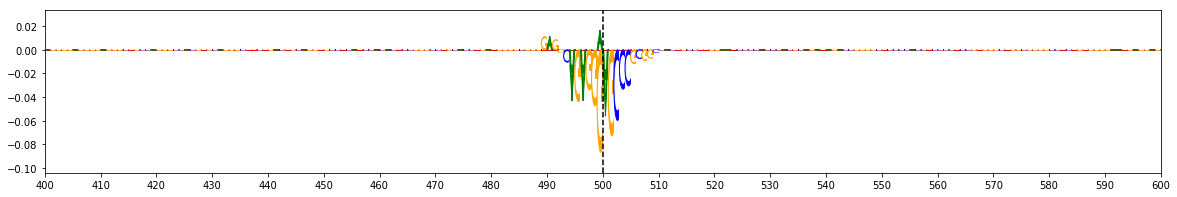


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs75541595   ||    chr4 : 90290372 - 90290373   ||    Locus: 587   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  5.30E-09

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.655   ||  Center / 200bp: 0.5744
Effect Sequence: CCAATGCCAGTATGTGGTTT


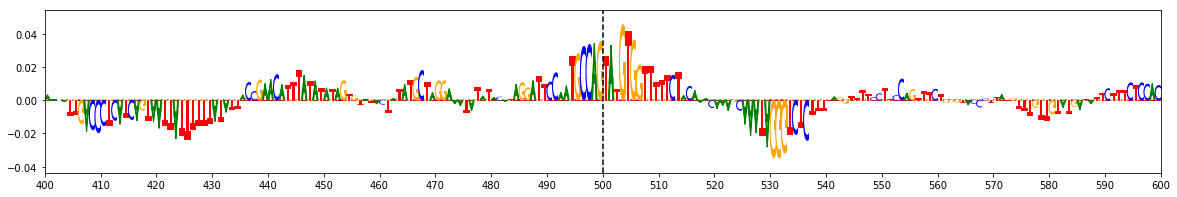

Noneffect Allele: A   ||  Explain Score: 0.3785   ||  Center / 200bp: 0.4382
Noneffect Sequence: CCAATGCCAATATGTGGTTT


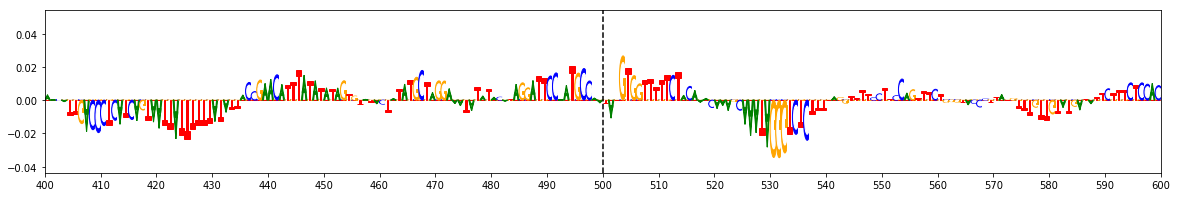

Allele Ratio : 1.7308   ||   Allele Difference : 0.2909  ||  ISM Score : 0.4572  ||  deltaSVM Score : 2.607


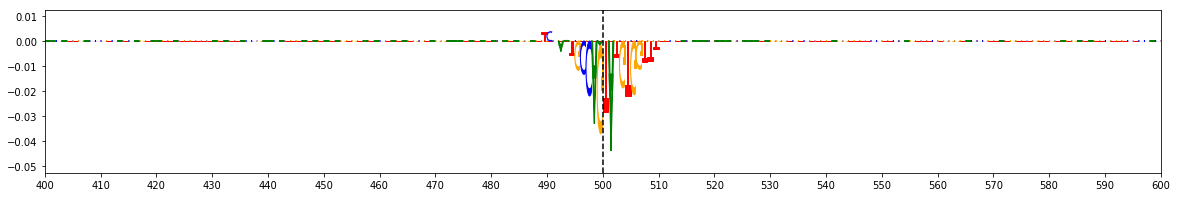


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62063291   ||    chr17 : 45966011 - 45966012   ||    Locus: 275   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.30E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.3129   ||  Center / 200bp: 0.2961
Effect Sequence: CCACCAAGCTCCCTTGGAAC


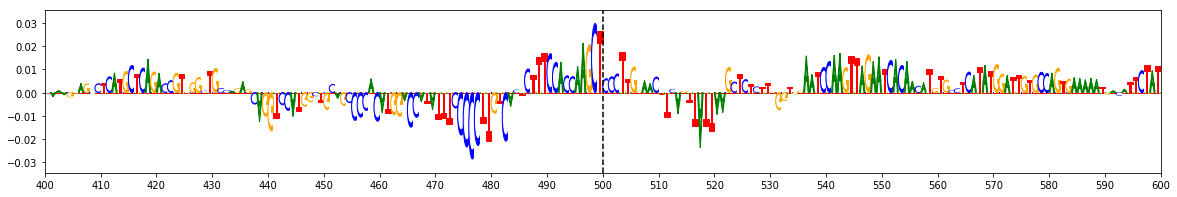

Noneffect Allele: C   ||  Explain Score: 0.0963   ||  Center / 200bp: 0.1142
Noneffect Sequence: CCACCAAGCCCCCTTGGAAC


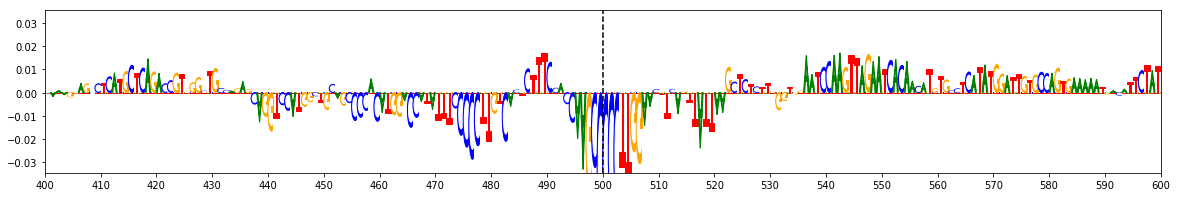

Allele Ratio : 3.2496   ||   Allele Difference : 0.742  ||  ISM Score : 1.159  ||  deltaSVM Score : 6.6362


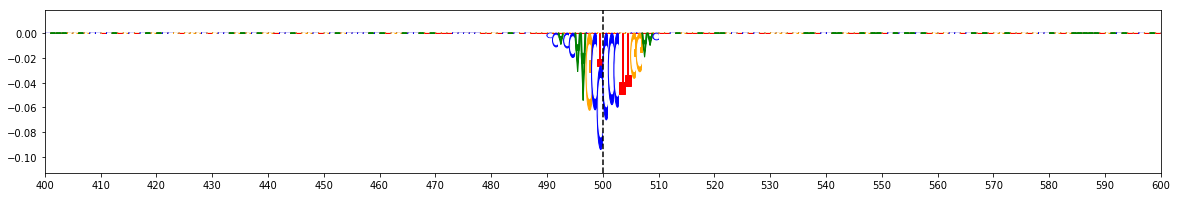


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs72800847   ||    chr16 : 31011317 - 31011318   ||    Locus: 106   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.45E-04

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.4848   ||  Center / 200bp: 0.2692
Effect Sequence: TTGTCCTTAGTGGGAGGGGA


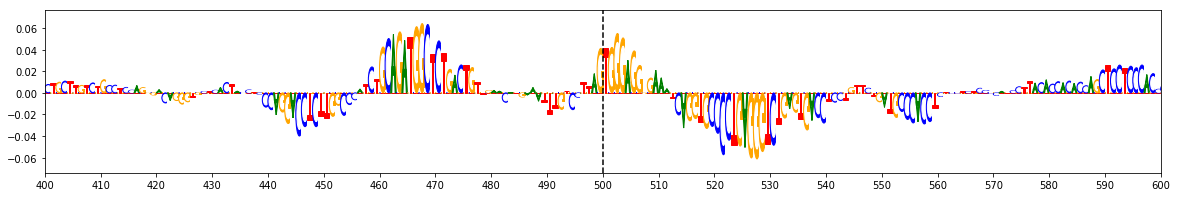

Noneffect Allele: A   ||  Explain Score: 0.1379   ||  Center / 200bp: 0.0948
Noneffect Sequence: TTGTCCTTAATGGGAGGGGA


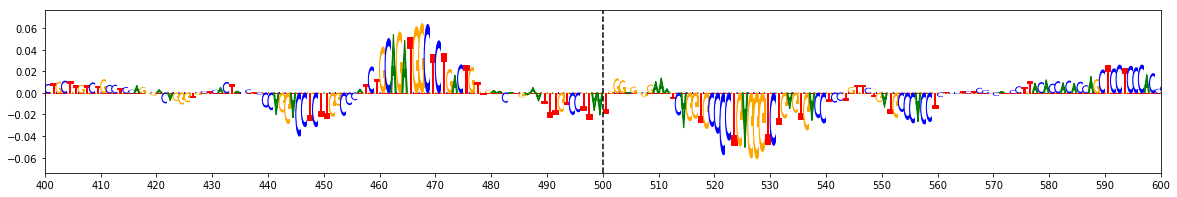

Allele Ratio : 3.515   ||   Allele Difference : 0.4869  ||  ISM Score : 0.768  ||  deltaSVM Score : 4.4065


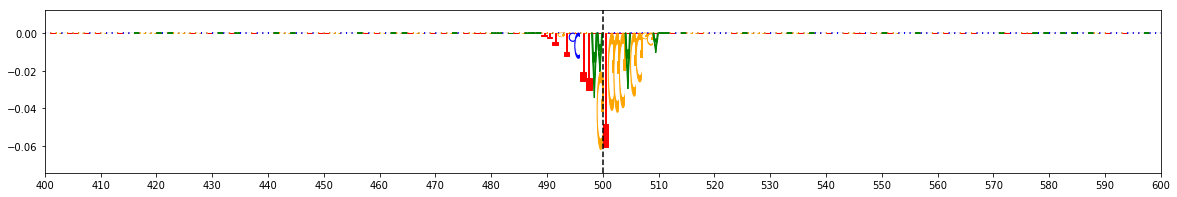


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs116839452   ||    chr1 : 154865462 - 154865463   ||    Locus: 1   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.61E-01

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.6687   ||  Center / 200bp: 0.4075
Effect Sequence: CCAGGCATAGTAATGAGAAG


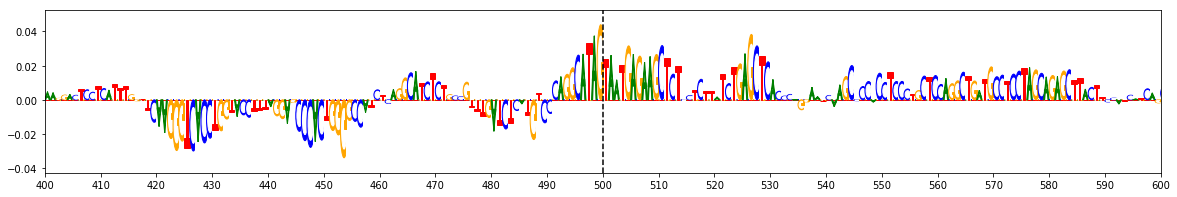

Noneffect Allele: A   ||  Explain Score: 0.2883   ||  Center / 200bp: 0.2287
Noneffect Sequence: CCAGGCATAATAATGAGAAG


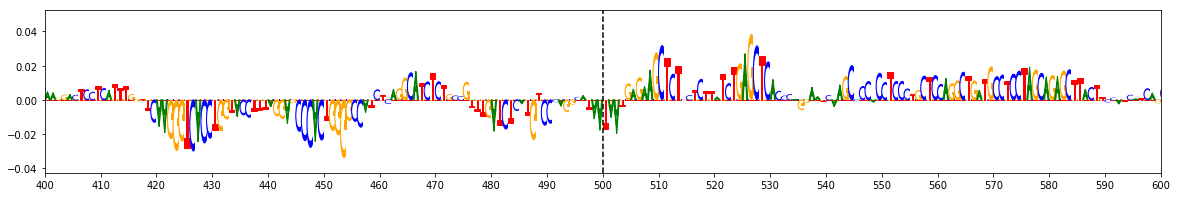

Allele Ratio : 2.3198   ||   Allele Difference : 0.4869  ||  ISM Score : 0.7638  ||  deltaSVM Score : 4.4033


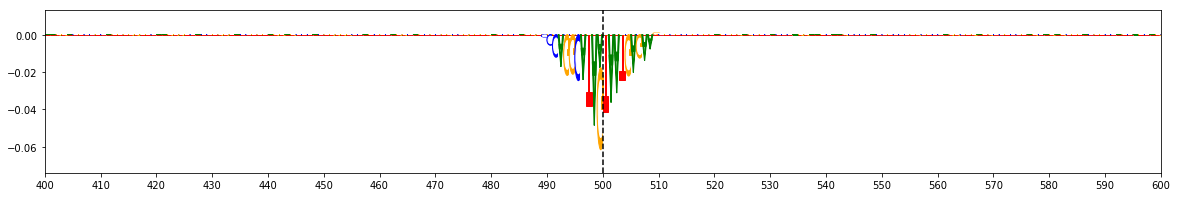


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34806123   ||    chr4 : 89762970 - 89762971   ||    Locus: 550   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.20E-22

Coloc:  False

Effect Allele: G   ||  Explain Score: 1.2807   ||  Center / 200bp: 0.7674
Effect Sequence: ACAGTTGGTGAGTAGGAAAG


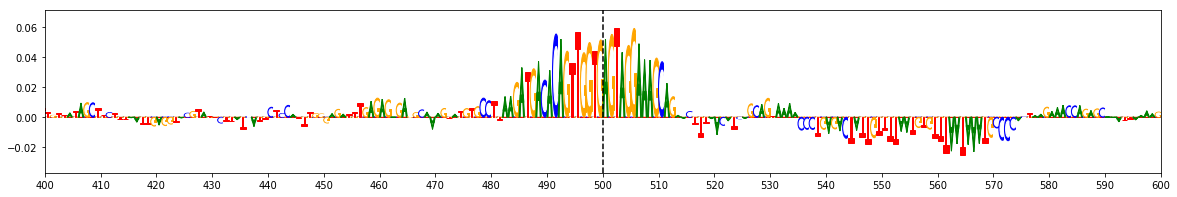

Noneffect Allele: A   ||  Explain Score: 1.0484   ||  Center / 200bp: 0.7299
Noneffect Sequence: ACAGTTGGTAAGTAGGAAAG


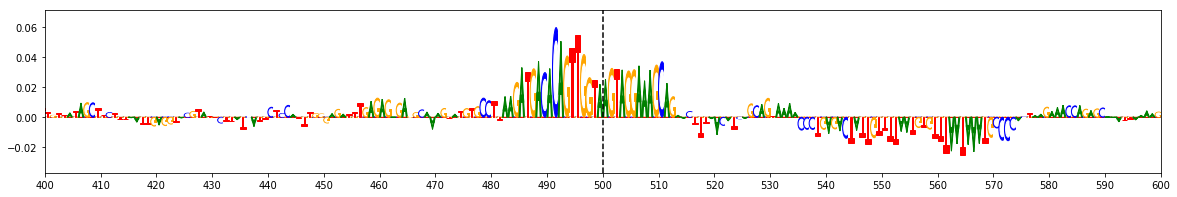

Allele Ratio : 1.2215   ||   Allele Difference : 0.2323  ||  ISM Score : 0.3638  ||  deltaSVM Score : 2.0665


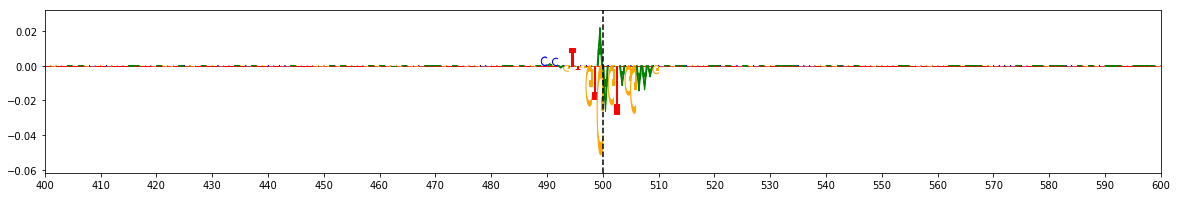


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs113661575   ||    chr5 : 134594466 - 134594467   ||    Locus: 596   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  3.40E-02

Coloc:  False

Effect Allele: G   ||  Explain Score: 1.098   ||  Center / 200bp: 0.6485
Effect Sequence: CTCAGCCTCGCAAAGTGCTG


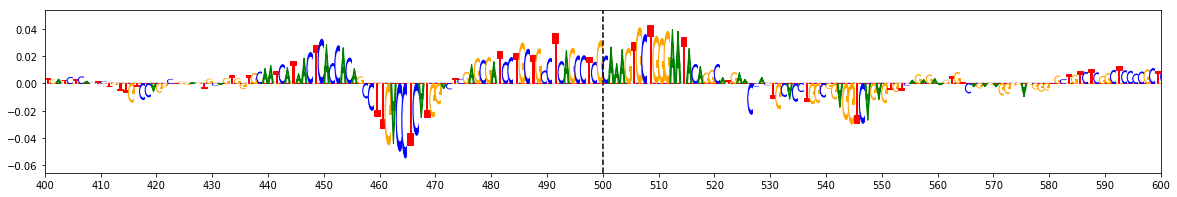

Noneffect Allele: C   ||  Explain Score: 0.7761   ||  Center / 200bp: 0.567
Noneffect Sequence: CTCAGCCTCCCAAAGTGCTG


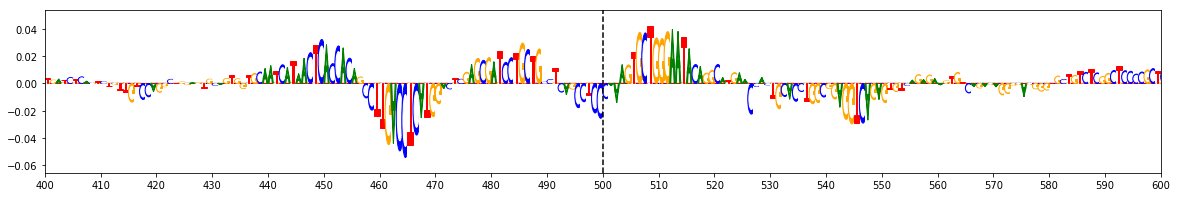

Allele Ratio : 1.4148   ||   Allele Difference : 0.4548  ||  ISM Score : 0.785  ||  deltaSVM Score : 4.5641


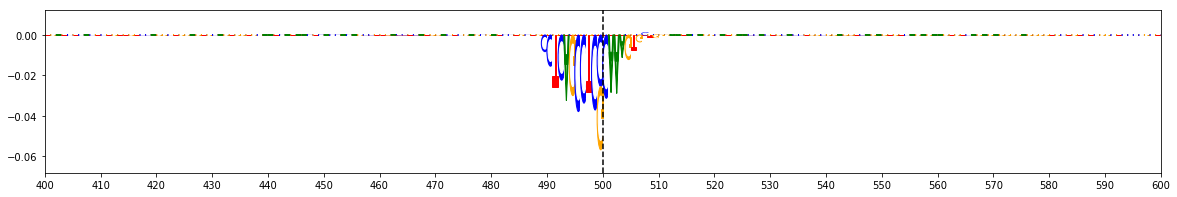


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7184567   ||    chr16 : 31009756 - 31009757   ||    Locus: 105   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  2.10E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.2652   ||  Center / 200bp: 0.3921
Effect Sequence: TCTGCATCCTCATCTCCCAC


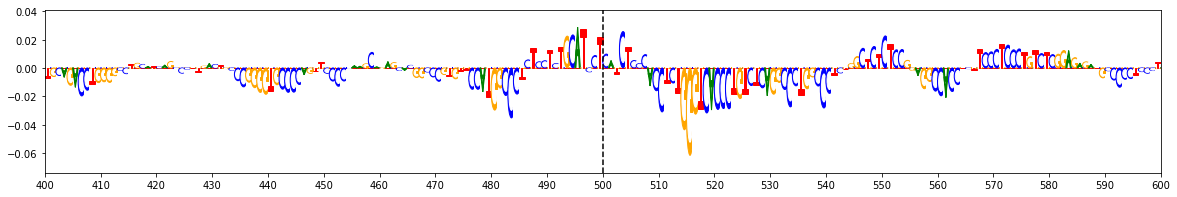

Noneffect Allele: C   ||  Explain Score: 0.114   ||  Center / 200bp: 0.2172
Noneffect Sequence: TCTGCATCCCCATCTCCCAC


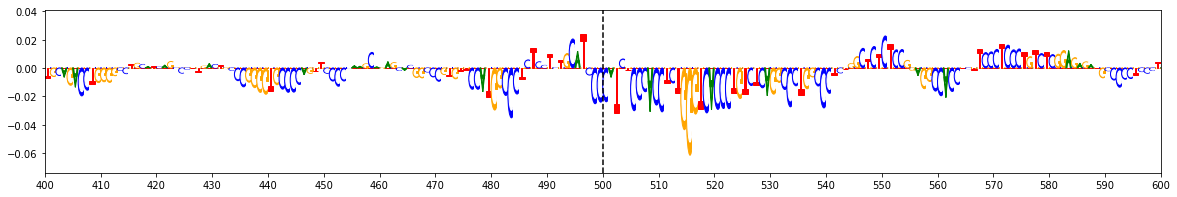

Allele Ratio : 2.3261   ||   Allele Difference : 0.3606  ||  ISM Score : 0.5762  ||  deltaSVM Score : 3.383


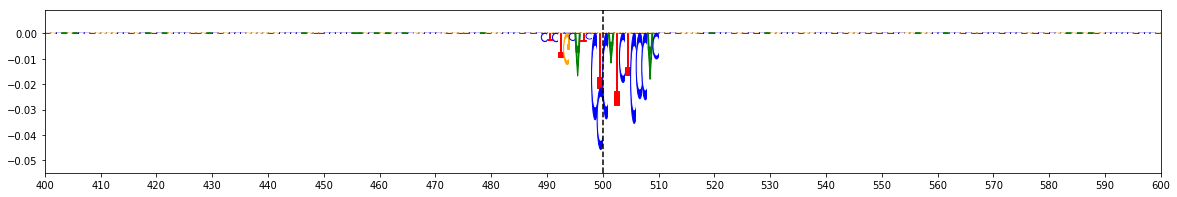


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62054424   ||    chr17 : 45742017 - 45742018   ||    Locus: 199   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.91E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.9422   ||  Center / 200bp: 0.5186
Effect Sequence: GAAGGAGAGGCGGGGAGACG


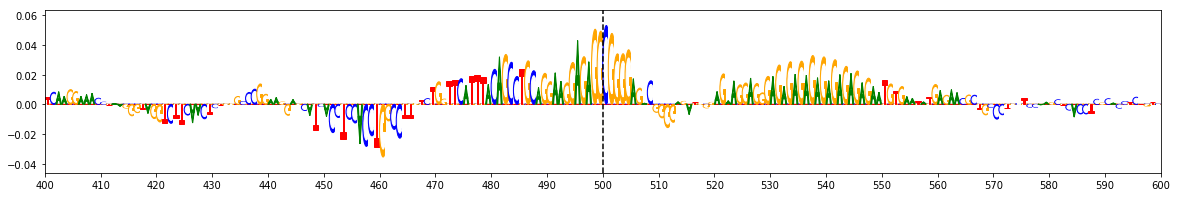

Noneffect Allele: A   ||  Explain Score: 0.545   ||  Center / 200bp: 0.3904
Noneffect Sequence: GAAGGAGAGACGGGGAGACG


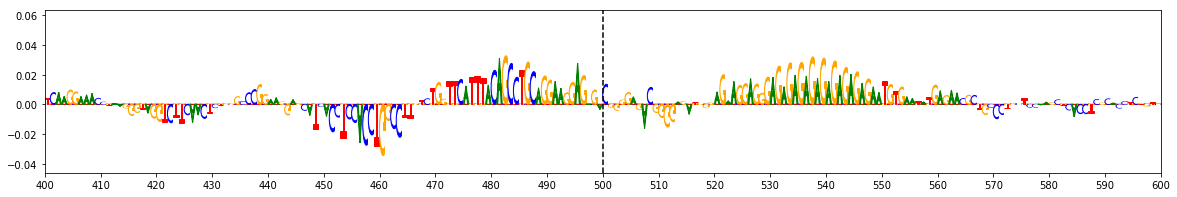

Allele Ratio : 1.7288   ||   Allele Difference : 0.4255  ||  ISM Score : 0.7522  ||  deltaSVM Score : 4.2351


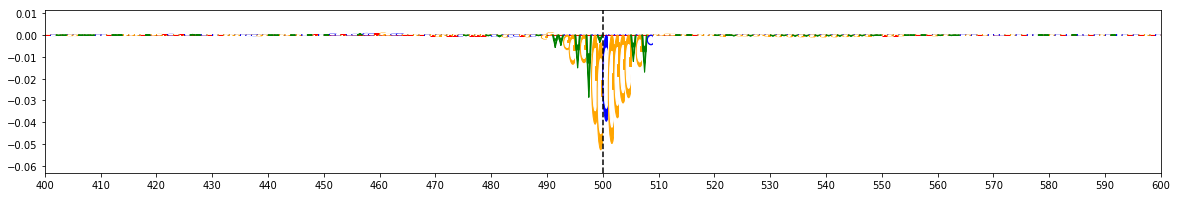


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs439401   ||    chr19 : 44911193 - 44911194   ||    Locus: 381   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.76E-165
Alzheimers_Kunkle_2019 		  7.61E-128
Alzheimers_Lambert_2013 	  3.54E-79

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.8916   ||  Center / 200bp: 0.6444
Effect Sequence: ACTCTCTTCTCCTCCCACCC


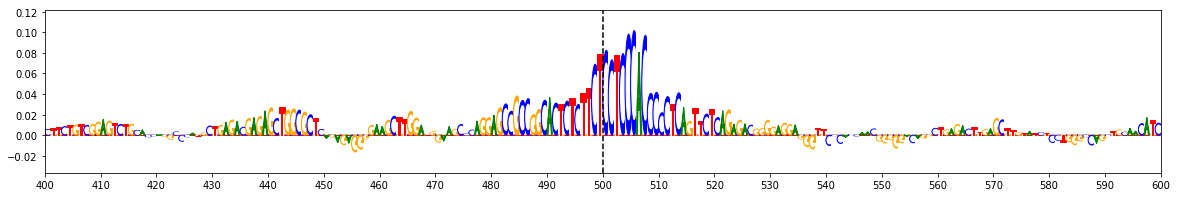

Noneffect Allele: C   ||  Explain Score: 1.371   ||  Center / 200bp: 0.5684
Noneffect Sequence: ACTCTCTTCCCCTCCCACCC


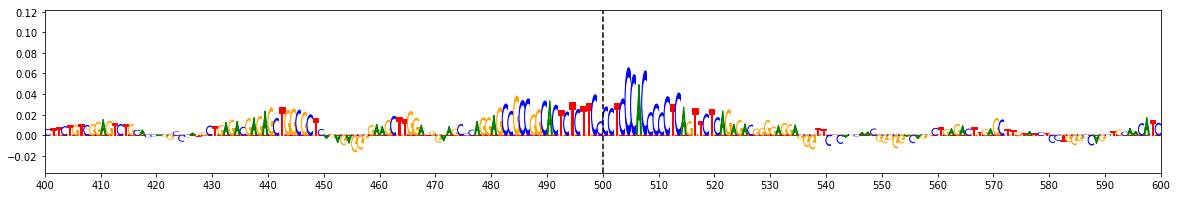

Allele Ratio : 1.3797   ||   Allele Difference : 0.5206  ||  ISM Score : 0.8162  ||  deltaSVM Score : 4.7317


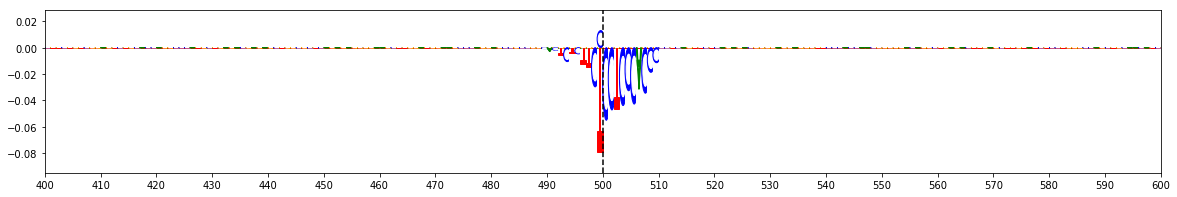


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs636341   ||    chr11 : 60251687 - 60251688   ||    Locus: 43   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  3.24E-13
Alzheimers_Kunkle_2019 		  4.96E-15
Alzheimers_Lambert_2013 	  1.41E-10

Coloc:  False

Effect Allele: A   ||  Explain Score: 3.736   ||  Center / 200bp: 0.7938
Effect Sequence: TCTGCTGGGAAATTGTGAAA


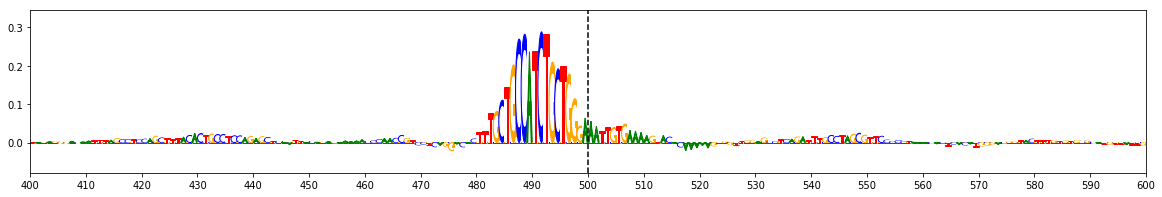

Noneffect Allele: C   ||  Explain Score: 3.3807   ||  Center / 200bp: 0.7771
Noneffect Sequence: TCTGCTGGGCAATTGTGAAA


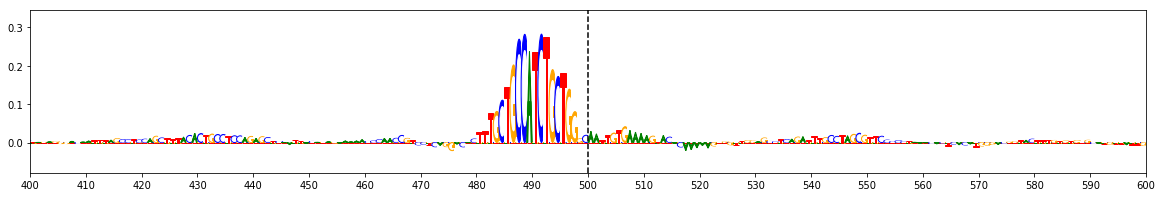

Allele Ratio : 1.1051   ||   Allele Difference : 0.3552  ||  ISM Score : 0.5506  ||  deltaSVM Score : 3.1529


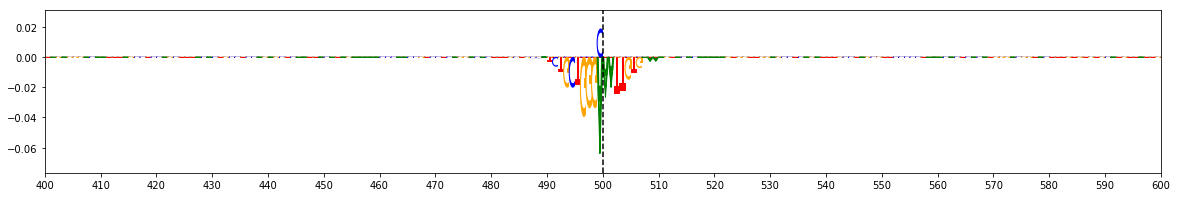


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()